In [2]:
from __future__ import division
%matplotlib inline
import numpy as np
import scipy.io as sio
import itertools
from matplotlib import pyplot as plt
import meta_features as mf
from scipy import interp
from sklearn.metrics import classification_report, roc_curve,  confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals import joblib
from collections import Counter

## Load data

In [18]:
data = sio.loadmat('../data/num_data_aug.mat')['data']
# Remove not tagged instances (e.g., Enrico's low frequency gameplay)
# 0 is the code for not tagged data. 

invalid_mprimitives = [i for i,d in enumerate(data) if d[-1] == 0]
print 'Invalids: {}'.format(invalid_mprimitives)
print 

data = data[data[:,-1] != 0]
print data

Invalids: [189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]

[[ 0.31612362  0.51076294  1.         ...,  1.19060919  3.42123432  1.        ]
 [ 0.23859909  0.30645777  1.         ...,  0.63196545  3.77933016  1.        ]
 [ 0.49870963  2.14520436  4.         ...,  6.29437589  2.68336024  3.        ]
 ..., 
 [ 0.49741322  3.27630447  6.         ...,  8.36395936  2.01679775  3.        ]
 [ 0.36464193  1.33099869  3.         ...,  3.3898593   2.84611253  2.        ]
 [ 0.57603441  2.45722835  4.         ...,  5.65549558  2.22981438  3.        ]]


In [19]:
X = data[:,:-3]  # Load X.
y = data[:,-1]   # Load y

#label remap
labels = {1: 'locally_moving', 2:'walk/dodging', 3:'running'}

In [22]:
res = joblib.load('matches.pkl') 
ci_prox = joblib.load('ci_proximity.pkl')
clf = joblib.load('classifier.pkl') 

In [25]:
proc_res = [(d['ci_means'],d['prox_means']) for i,d in enumerate(res) if i not in invalid_mprimitives]
assert len(data) == len(proc_res)

## Testing the activity formula

In [26]:
start = 182
end   = 188
interval = range(start,end+1,1)
print "Interval: {}".format(interval)

X_test = X[start:end]
y_test = y[start:end]

Interval: [182, 183, 184, 185, 186, 187, 188]


In [27]:
n_classes = 3
omega = [1, 30, 60]
#assert np.sum(omega) == 1

Interval number: 182
Starts at: 0.0
Ends at: 3.77859477124
Prediction [[ 0.  0.  1.]]
Energy: 0.333940578893
Activity_level: 20.04

Interval number: 183
Starts at: 7.45506535948
Ends at: 14.7058823529
Prediction [[ 0.  1.  0.]]
Energy: 0.18091922727
Activity_level: 5.43

Interval number: 184
Starts at: 16.8504901961
Ends at: 19.7099673203
Prediction [[ 0.  1.  0.]]
Energy: 0.220511796397
Activity_level: 6.62

Interval number: 185
Starts at: 22.6715686275
Ends at: 26.1437908497
Prediction [[ 0.  1.  0.]]
Energy: 0.185811198357
Activity_level: 5.57

Interval number: 186
Starts at: 27.0629084967
Ends at: 31.760620915
Prediction [[ 0.   0.2  0.8]]
Energy: 0.321346755219
Activity_level: 17.35

Interval number: 187
Starts at: 32.3733660131
Ends at: 35.6413398693
Prediction [[ 0.   0.4  0.6]]
Energy: 0.273715416061
Activity_level: 13.14

Interval number: 188
Starts at: 36.2540849673
Ends at: 36.8668300654
Prediction [[ 1.  0.  0.]]
Energy: 0.0666574517456
Activity_level: 0.07



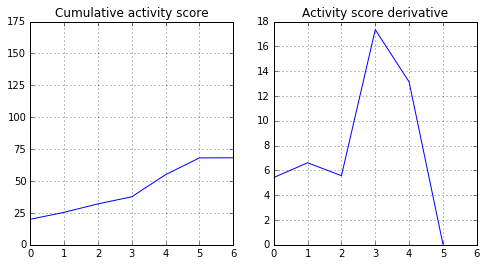

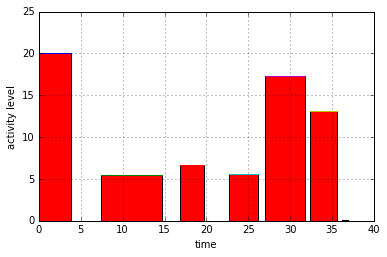

In [28]:
import matplotlib.patches as patches
preds = []
act_level = []
sums = []
begins = []
ends = []
for i in interval:
    print 'Interval number: {}'.format(i)
    print 'Starts at: {}'.format(res[i]['dt_samples'][0])
    begins.append(res[i]['dt_samples'][0])
    print 'Ends at: {}'.format(res[i]['dt_samples'][-1])
    ends.append(res[i]['dt_samples'][-1])
    pred = clf.predict_proba(X[i].reshape(1,-1))
    print 'Prediction {}'.format(pred)
    preds.append(pred)
    summation = 0
    epsilon = mf.energy(res[i]['act'])
    print 'Energy: {}'.format(epsilon)
    for j in range(n_classes):
        summation += omega[j]*pred[0][j]*epsilon
    if len(sums) == 0:
        sums.append(summation)
    else:
        sums.append(sums[-1]+summation)
    act_level.append(summation)
    print 'Activity_level: {:.2f}'.format(summation)
    print

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax.plot(sums)
ax.set_yticks(range(0,200,25))
ax.set_xticks(range(len(sums)))
ax.grid()
ax.set_title('Cumulative activity score')

ax2 = fig.add_subplot(122)
dev = np.diff(sums)
ax2.plot(dev)
ax2.set_xticks(range(len(sums)))
ax2.grid()
ax2.set_title('Activity score derivative')
plt.show()


fig = plt.figure()
ax3 = fig.add_subplot(111, aspect='equal')

for i, (b,e) in enumerate(zip(begins,ends)):
    xs = np.linspace(b,e,100)
    ys = np.ones_like(xs) * act_level[i]
    
    p = patches.Rectangle(
        (xs[0], 0), e-b, act_level[i], facecolor="red", #fill=False,
        linewidth=None,      # Default
    )
    ax3.plot(xs,ys)
    ax3.add_patch(p)
plt.xlabel('time')
plt.ylabel('activity level')
plt.grid()
plt.show()

## Fuzzy

iteration: 0
ERROR! Session/line number was not unique in database. History logging moved to new session 631
interaction_level: 0.792084104195
gain factor: 3

iteration: 1
interaction_level: 0.0333333333333
gain factor: 1

iteration: 2
interaction_level: 0.397971355005
gain factor: 2

iteration: 3
interaction_level: 0.0333333333333
gain factor: 1

iteration: 4
interaction_level: 0.787235230731
gain factor: 3

iteration: 5
interaction_level: 0.52248498296
gain factor: 2

iteration: 6
interaction_level: 0.584438845542
gain factor: 2

iteration: 7
interaction_level: 0.612460701572
gain factor: 3

iteration: 8
interaction_level: 0.63047160957
gain factor: 3

iteration: 9
interaction_level: 0.59977843635
gain factor: 2

iteration: 10
interaction_level: 0.67443824909
gain factor: 3

iteration: 11
interaction_level: 0.117790396327
gain factor: 1

iteration: 12
interaction_level: 0.504218147
gain factor: 2

iteration: 13
interaction_level: 0.0333333333333
gain factor: 1

iteration: 14
interact

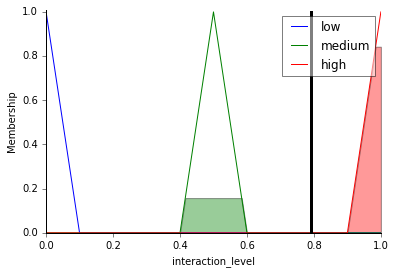

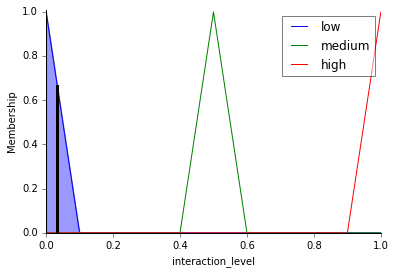

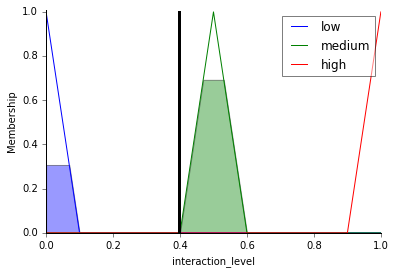

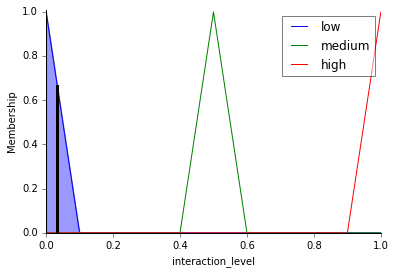

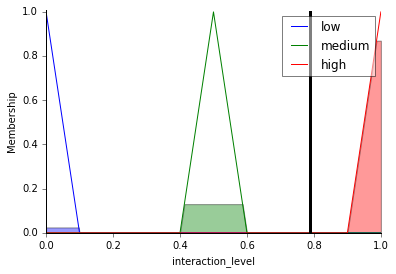

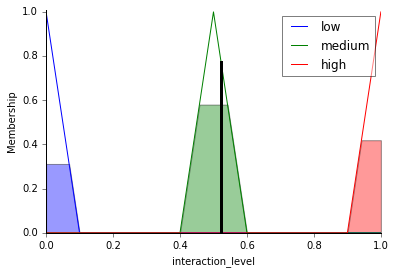

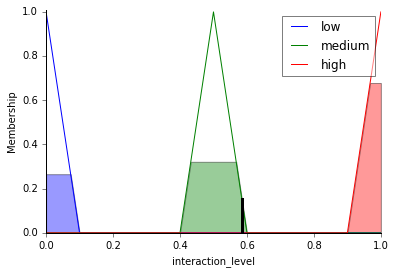

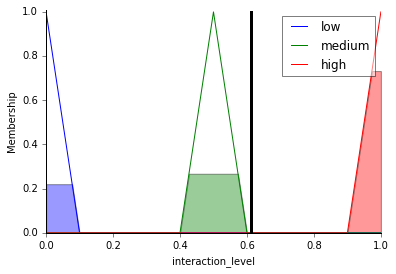

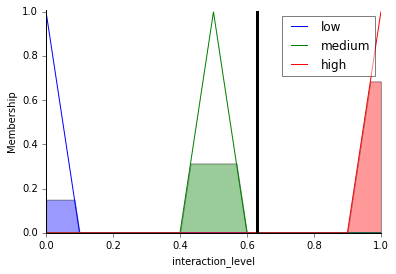

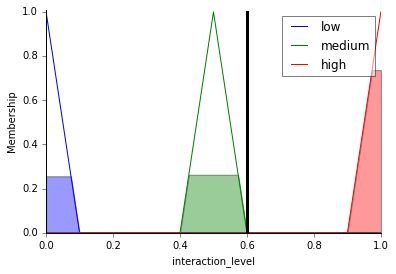

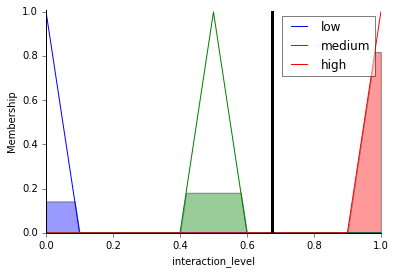

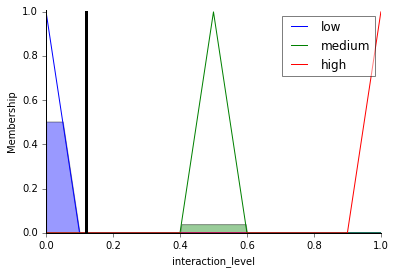

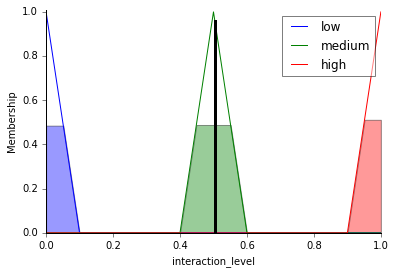

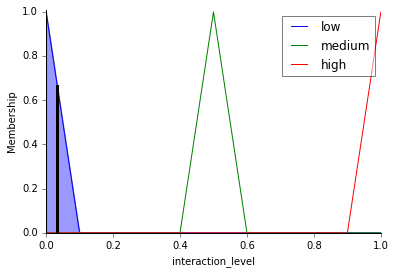

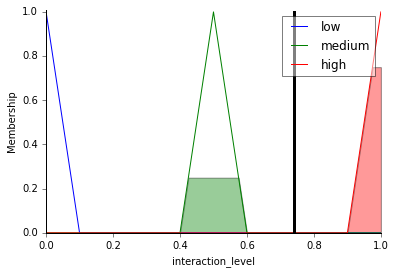

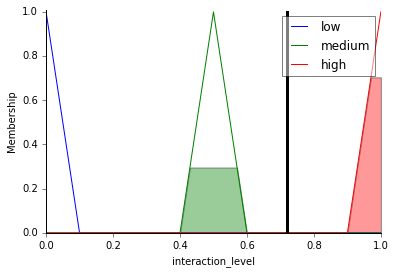

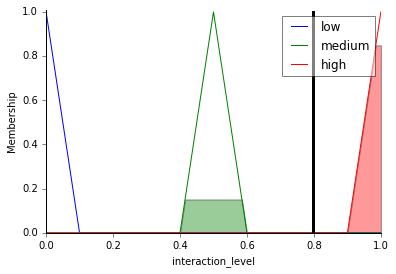

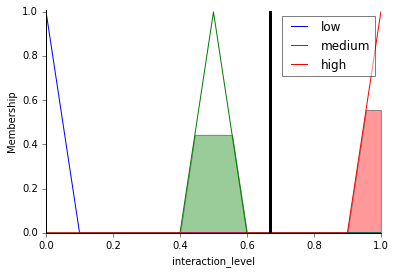

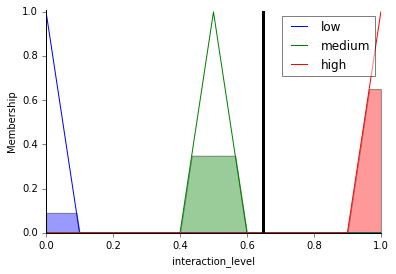

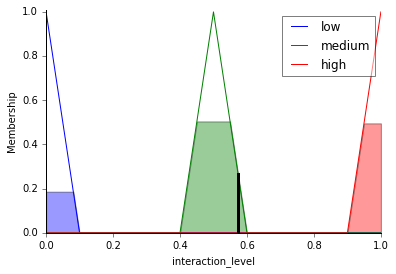

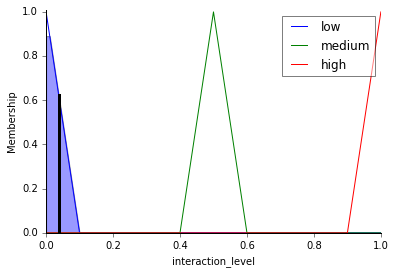

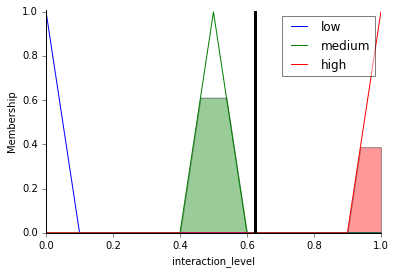

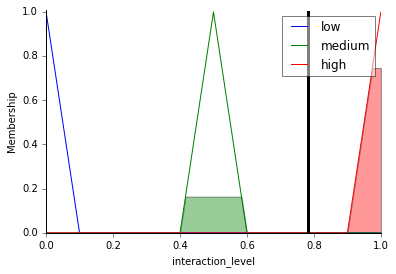

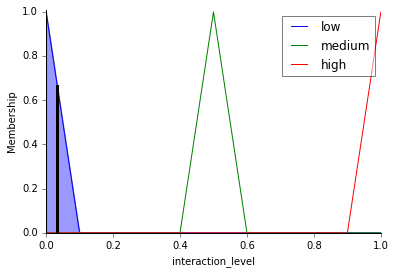

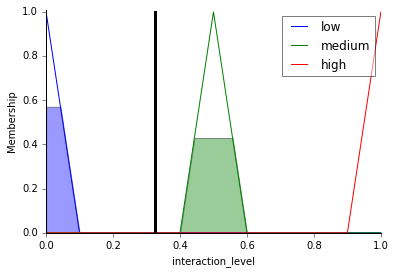

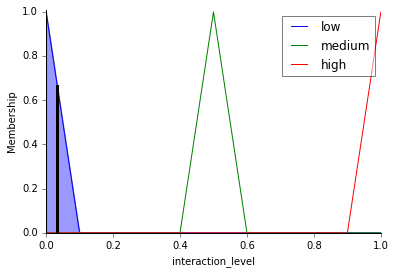

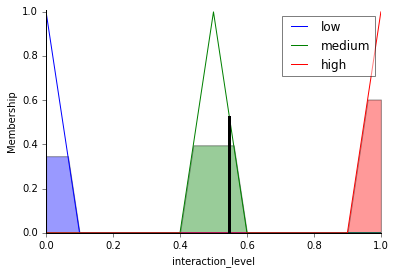

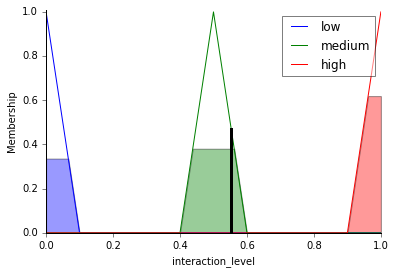

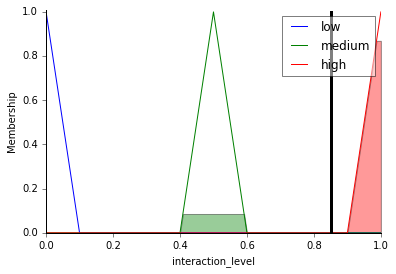

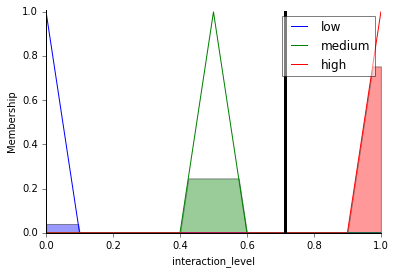

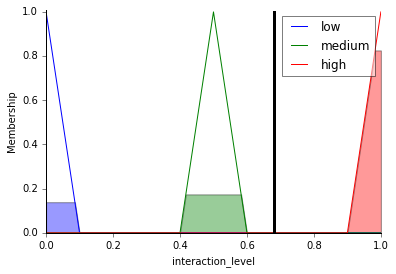

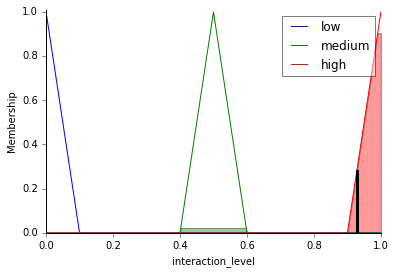

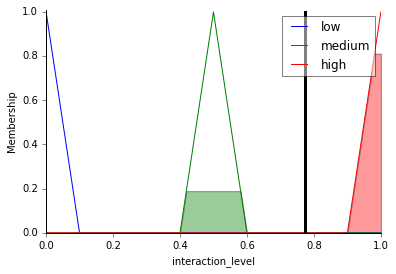

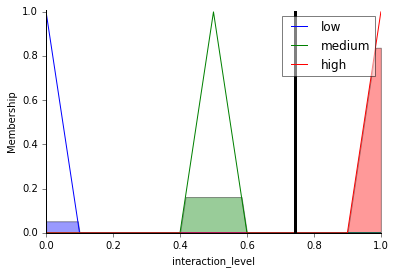

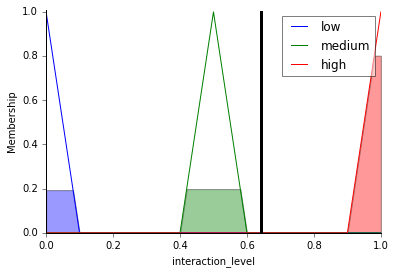

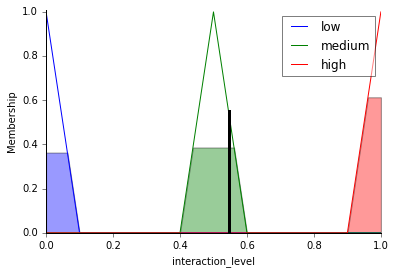

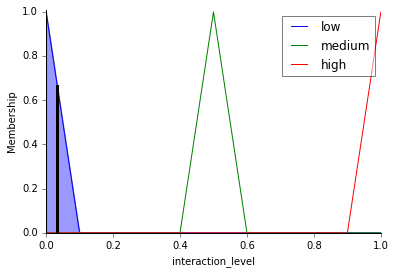

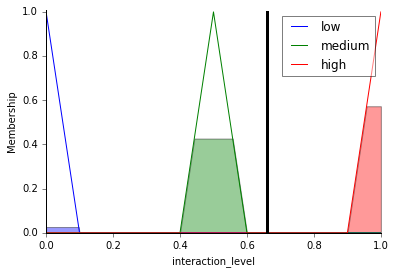

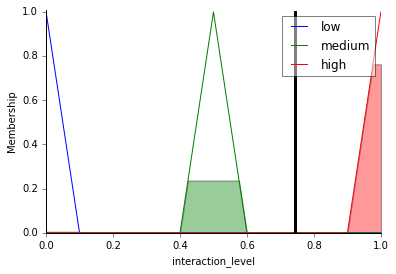

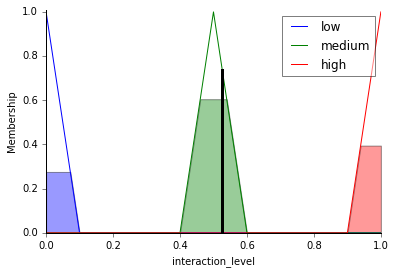

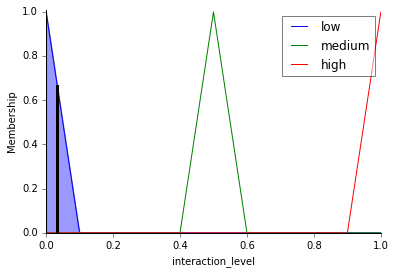

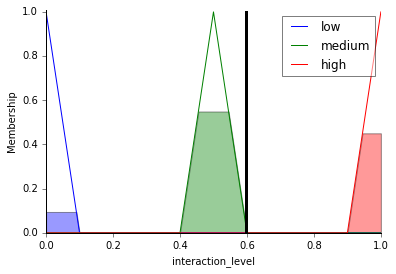

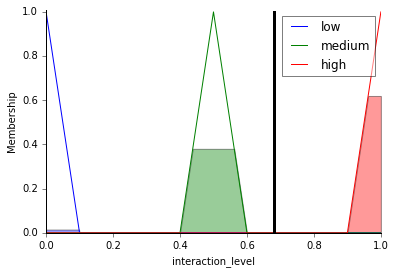

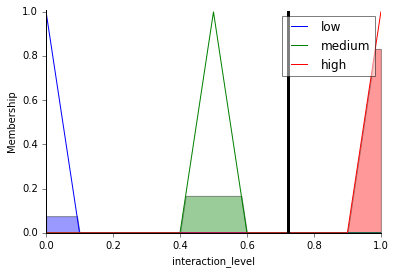

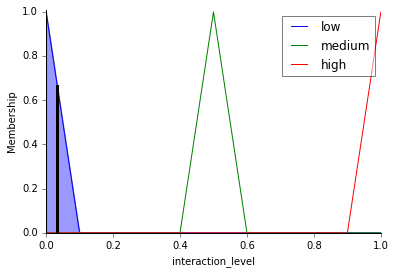

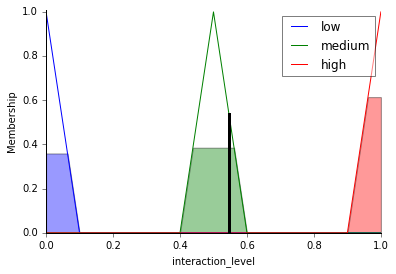

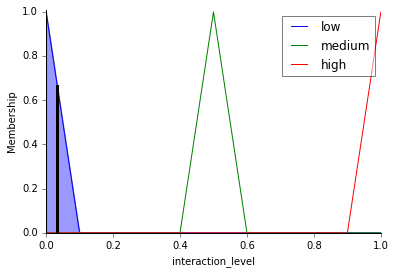

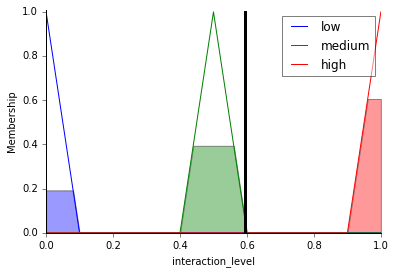

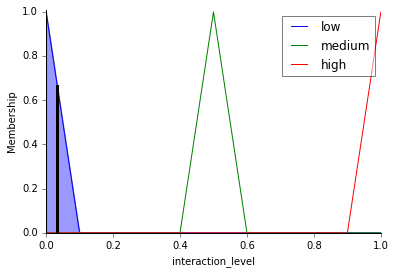

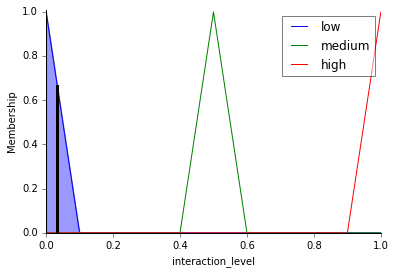

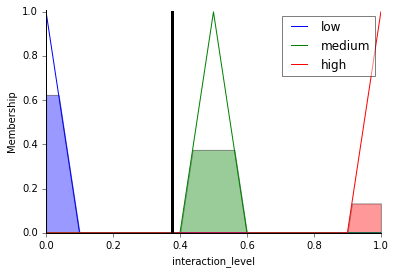

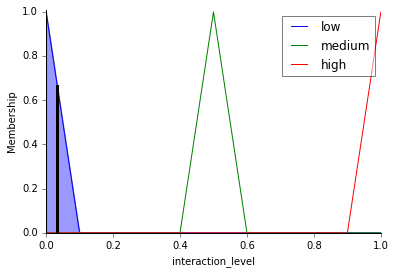

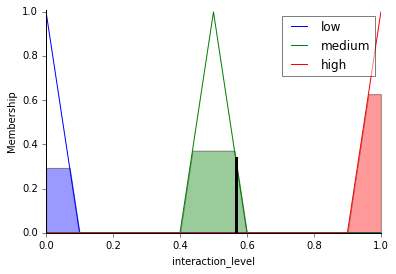

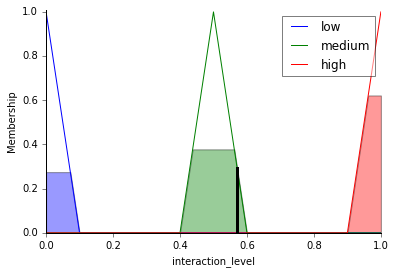

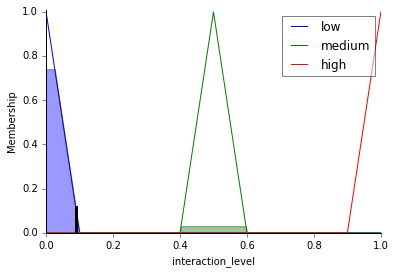

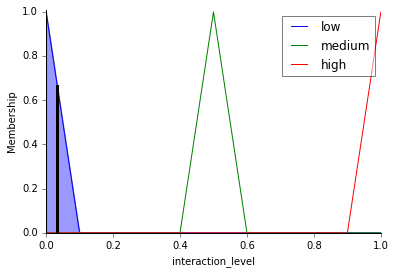

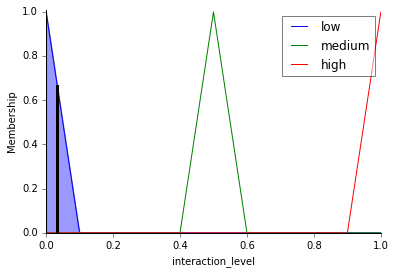

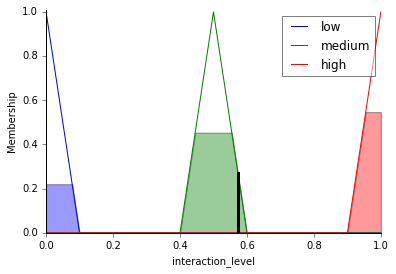

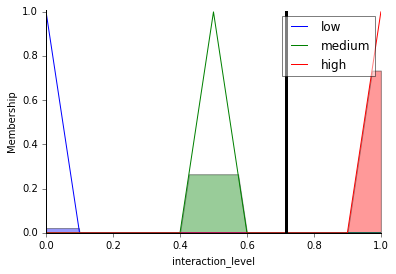

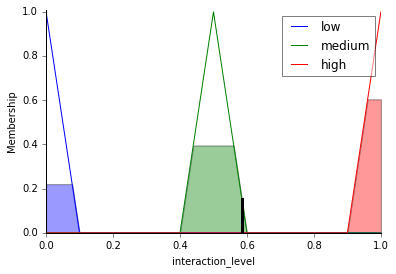

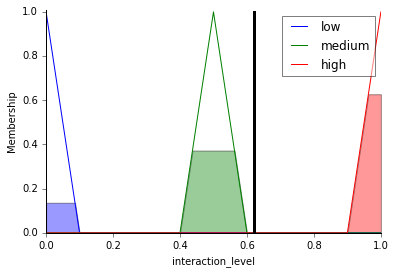

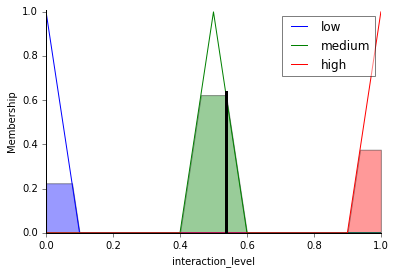

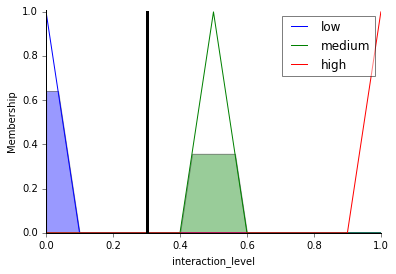

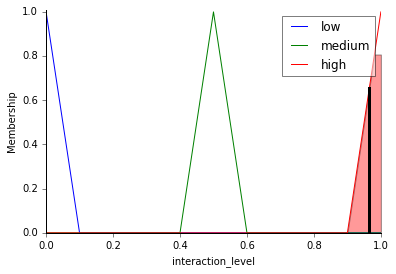

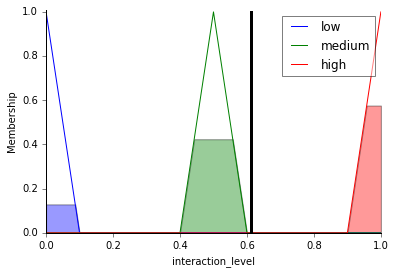

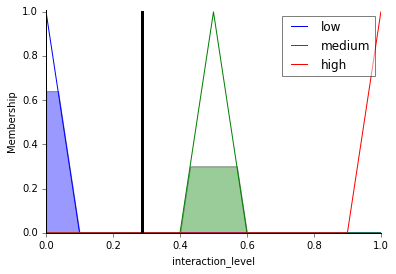

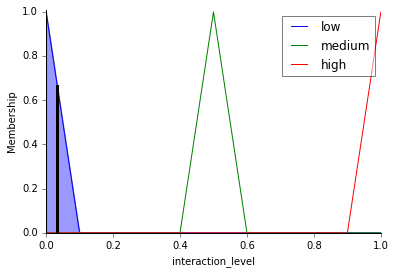

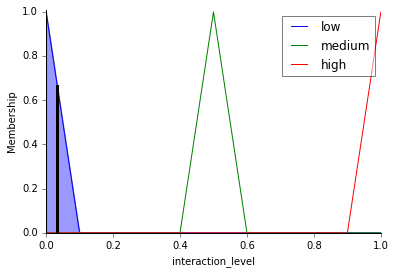

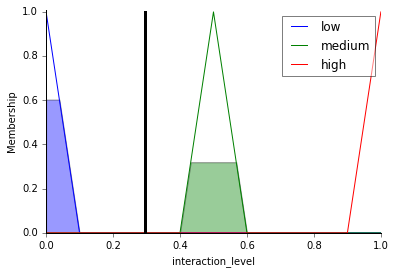

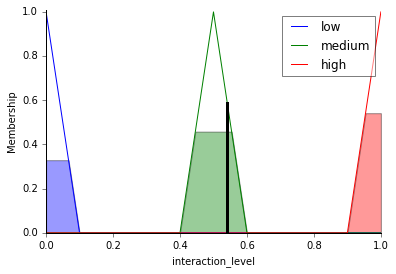

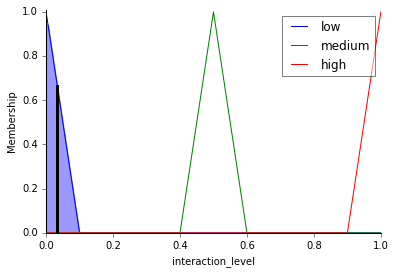

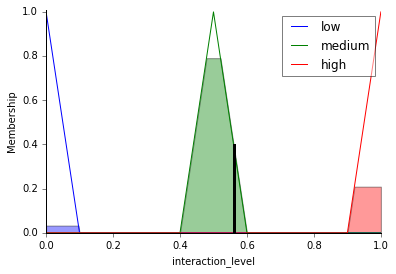

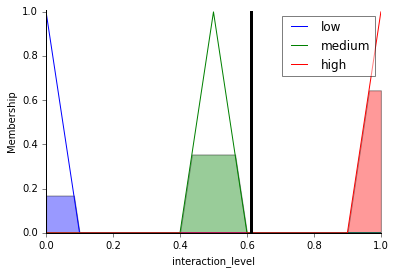

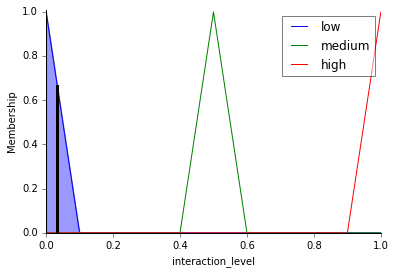

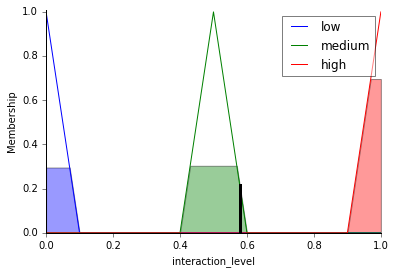

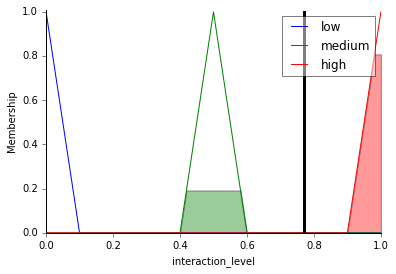

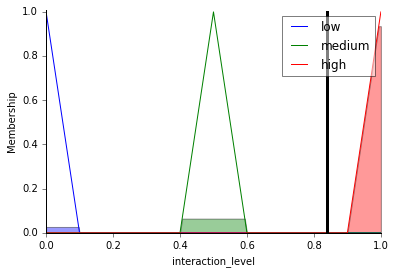

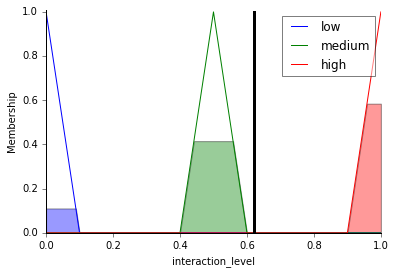

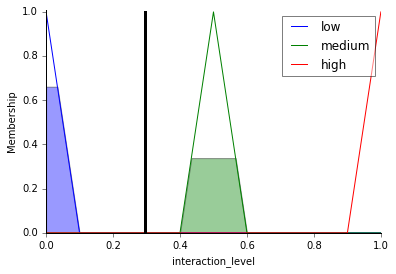

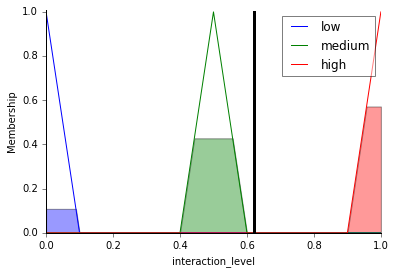

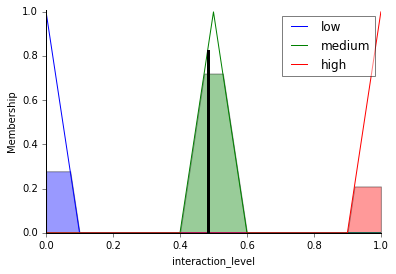

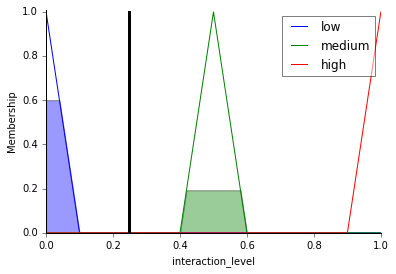

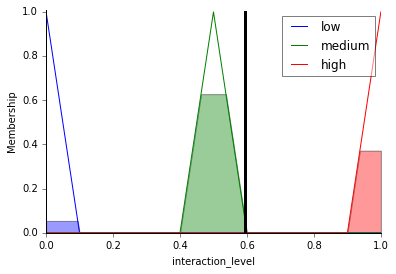

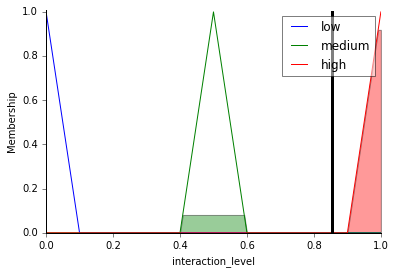

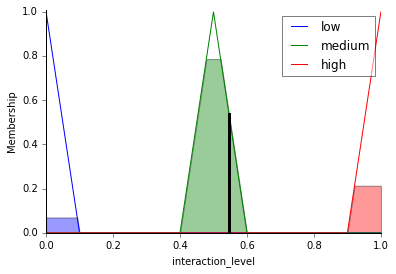

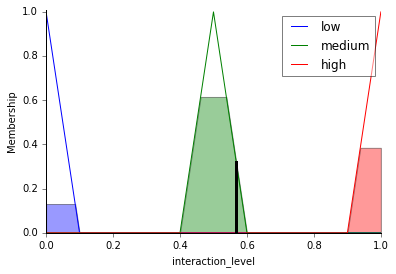

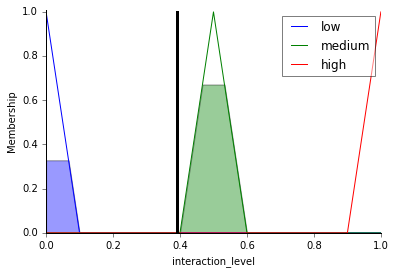

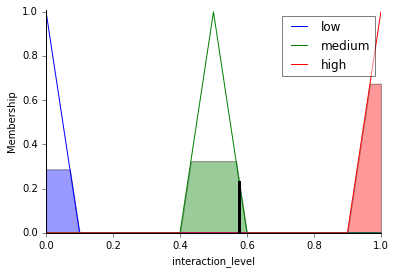

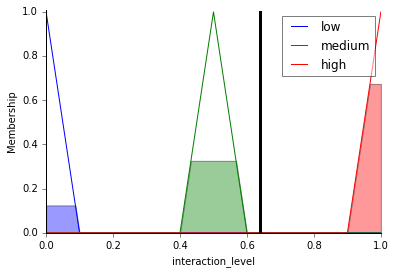

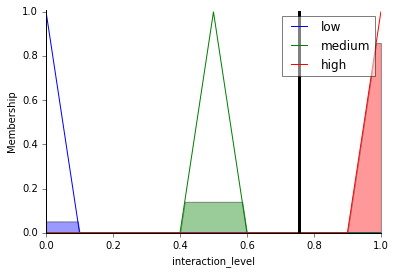

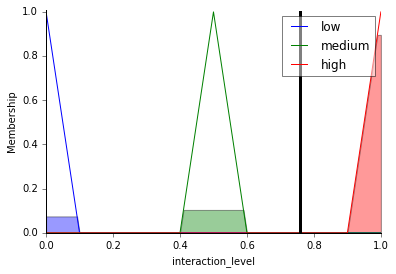

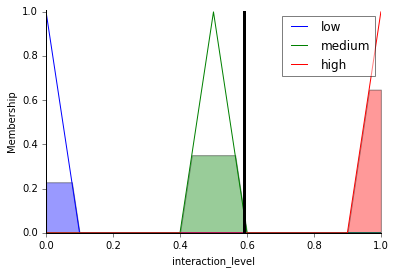

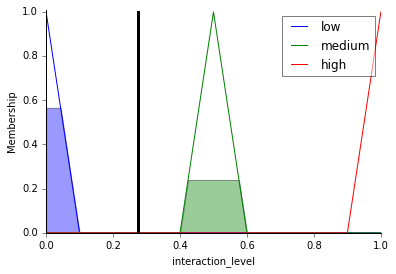

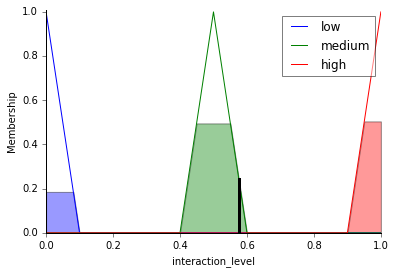

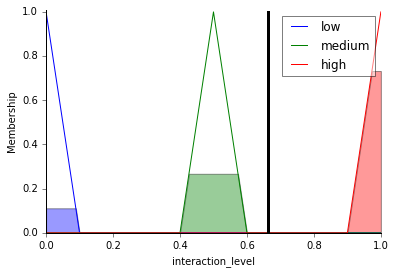

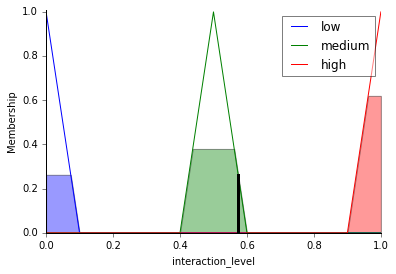

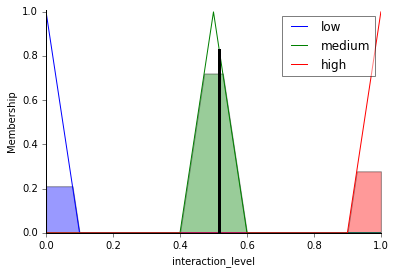

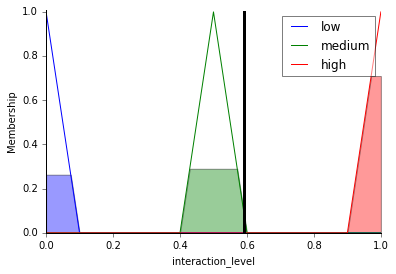

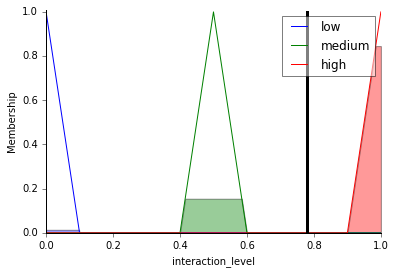

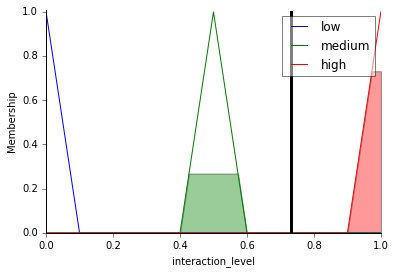

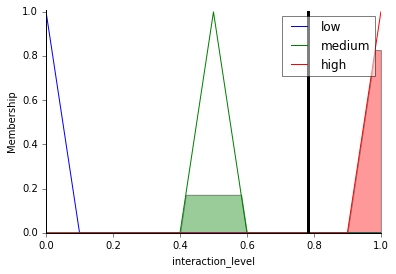

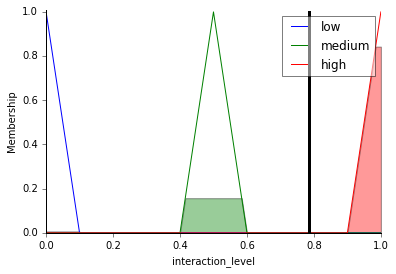

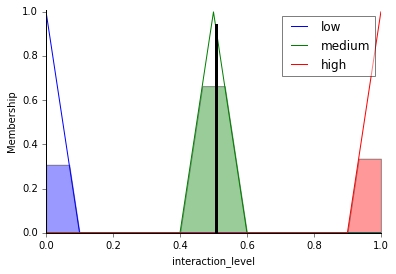

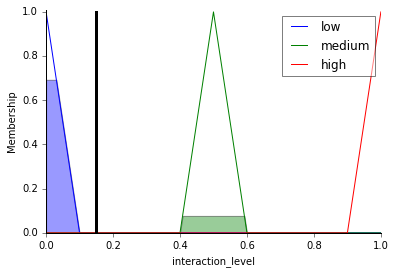

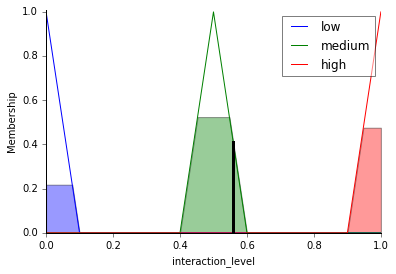

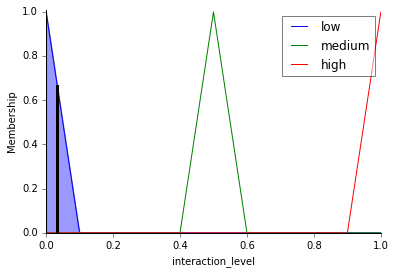

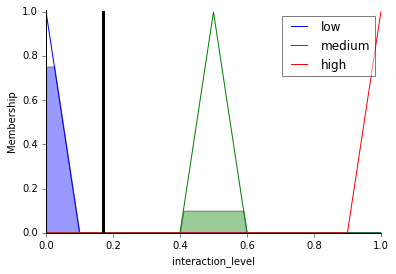

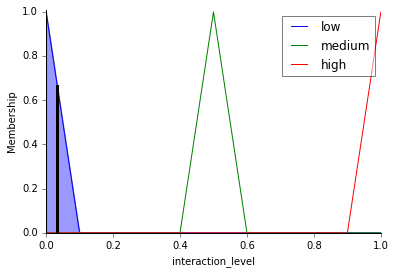

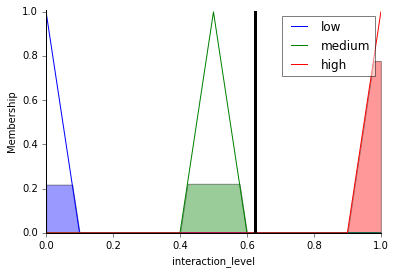

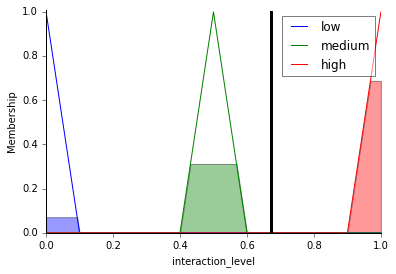

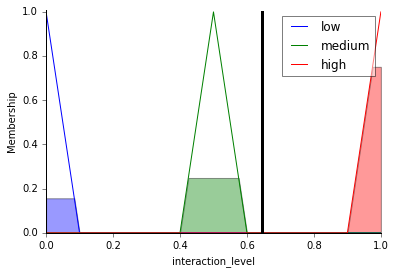

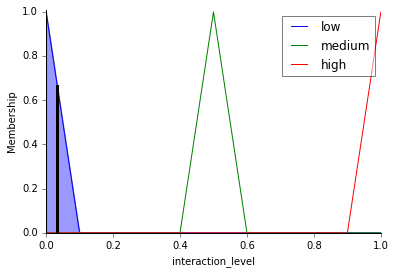

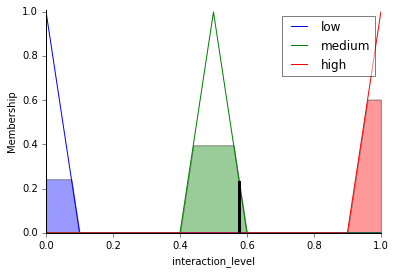

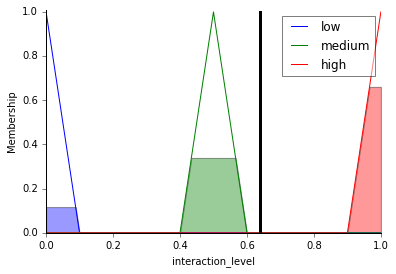

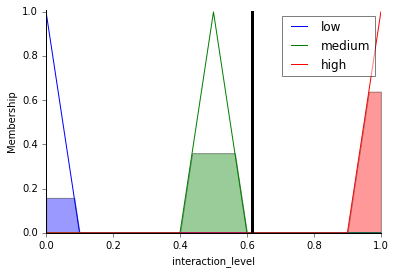

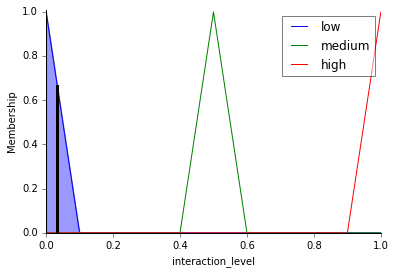

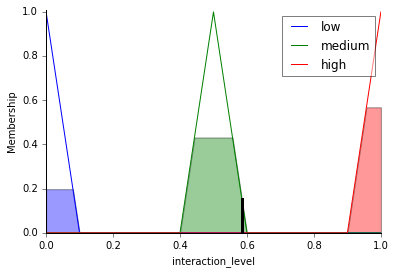

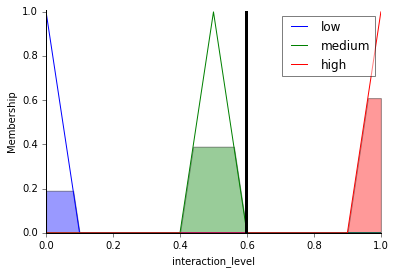

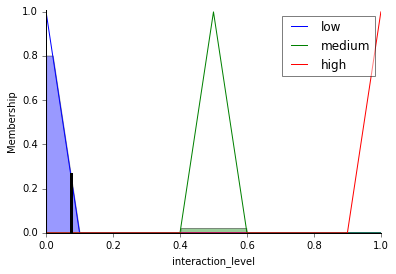

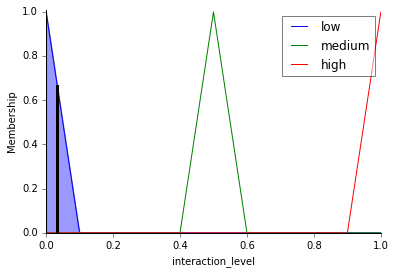

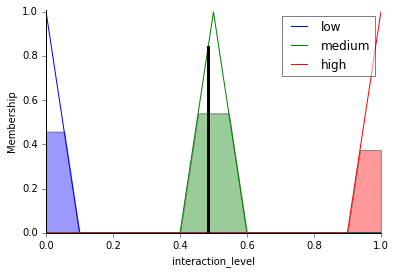

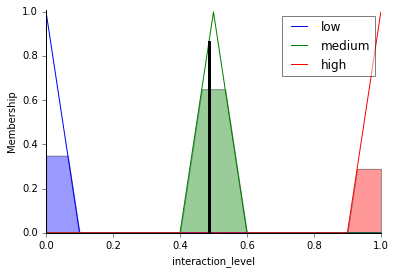

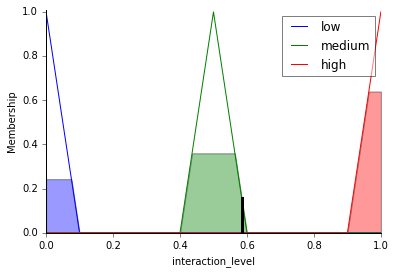

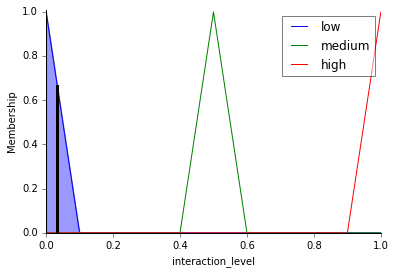

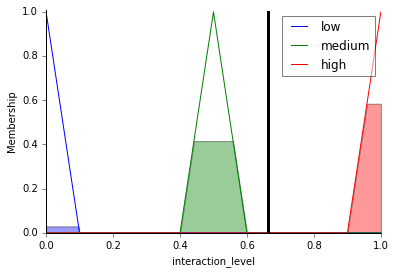

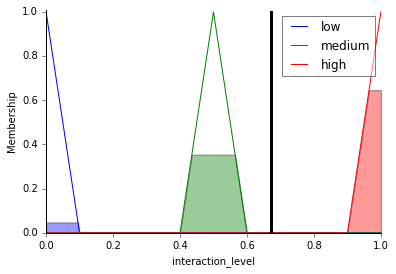

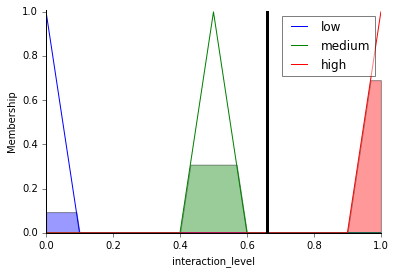

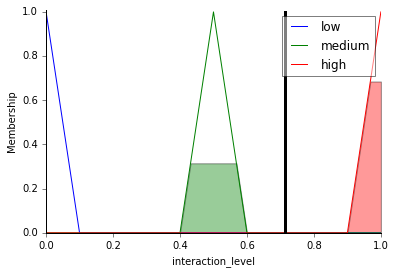

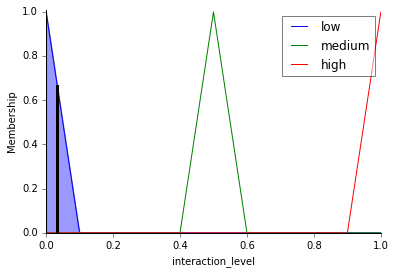

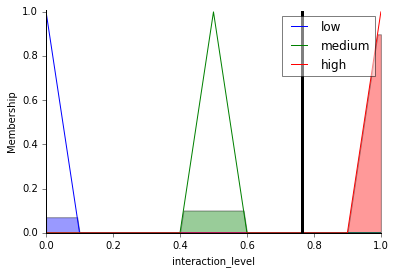

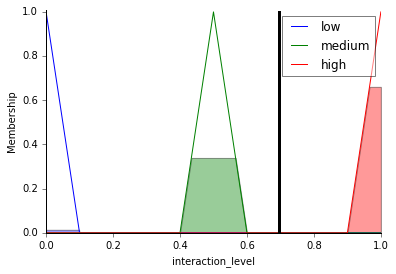

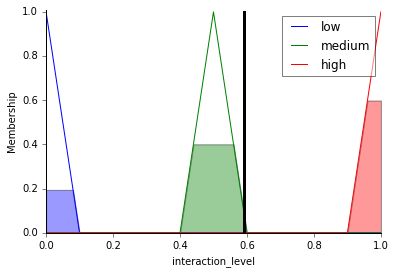

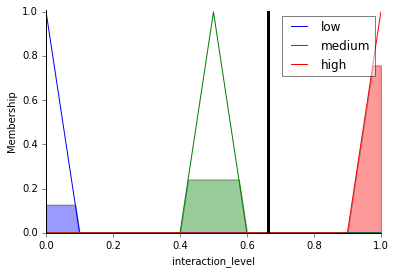

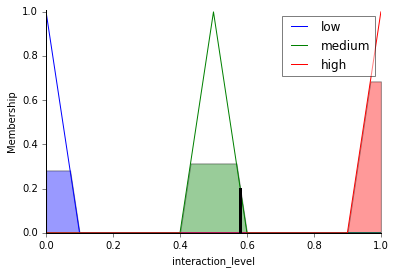

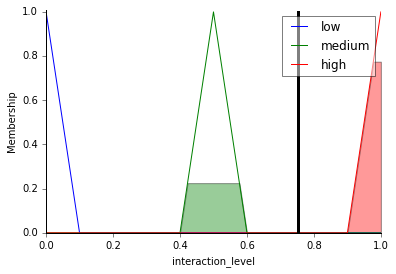

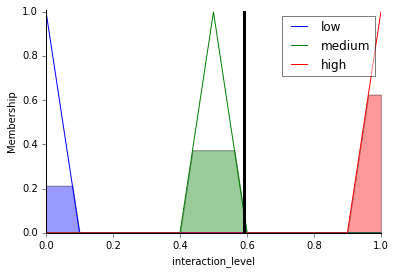

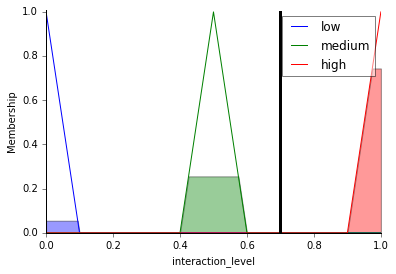

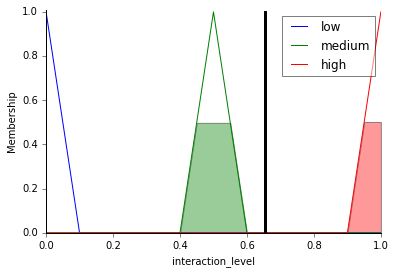

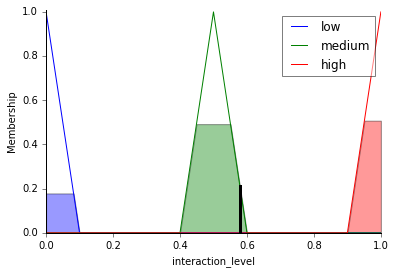

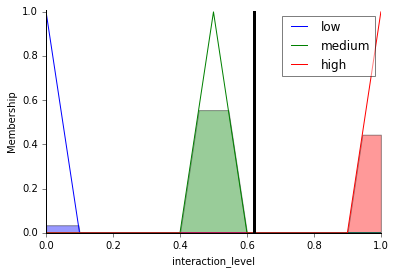

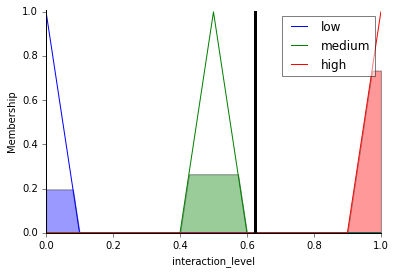

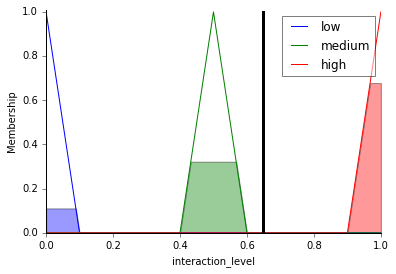

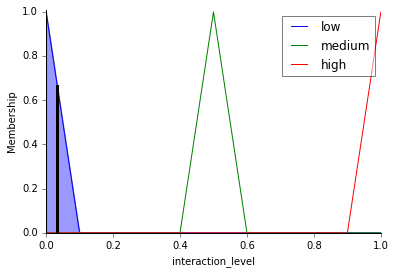

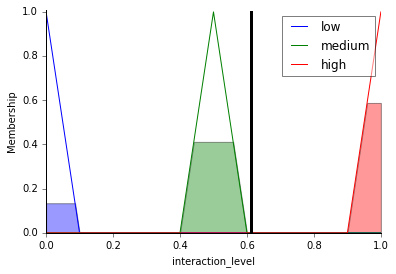

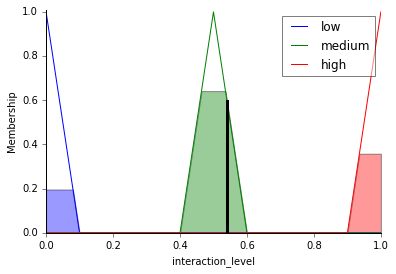

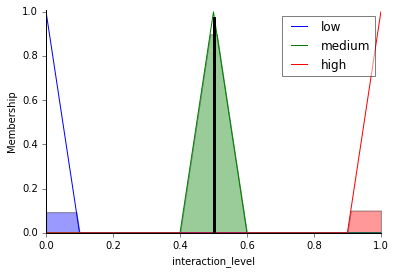

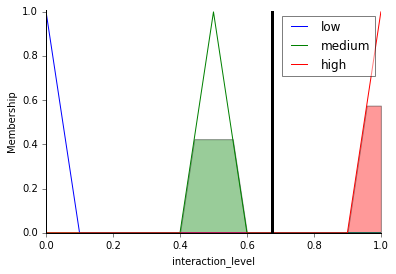

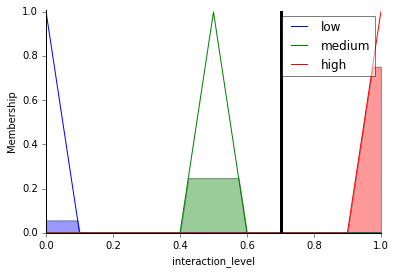

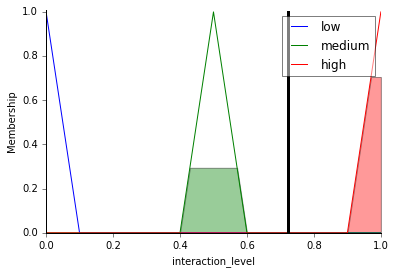

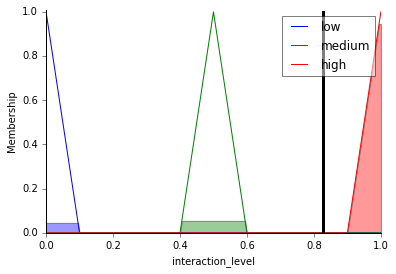

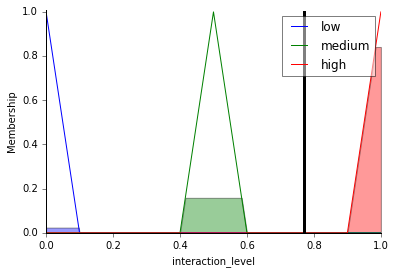

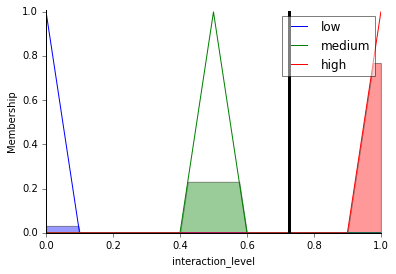

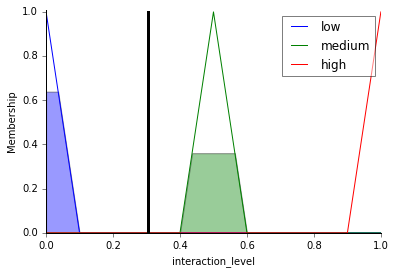

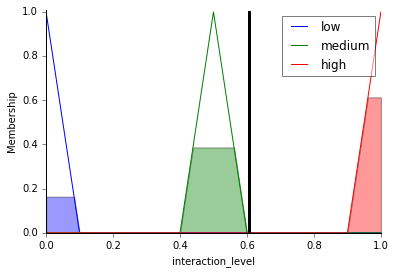

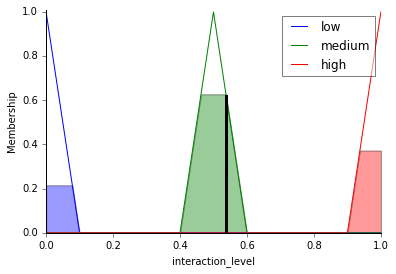

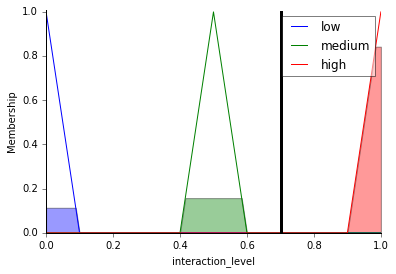

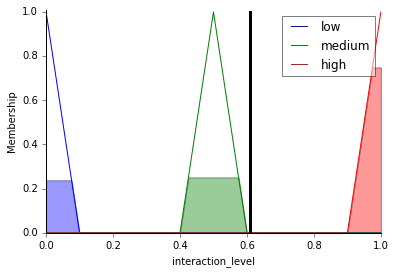

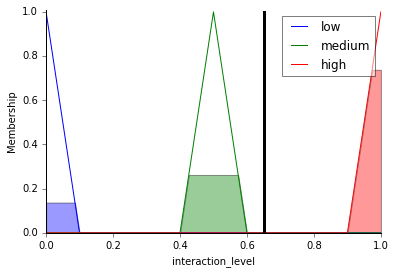

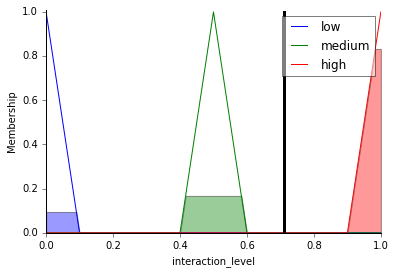

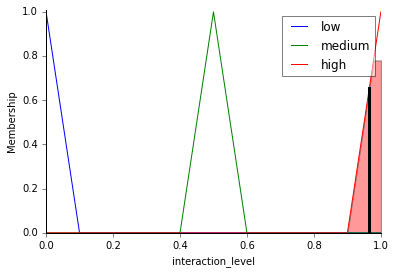

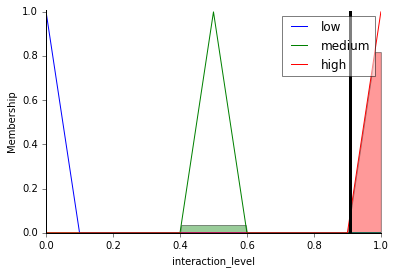

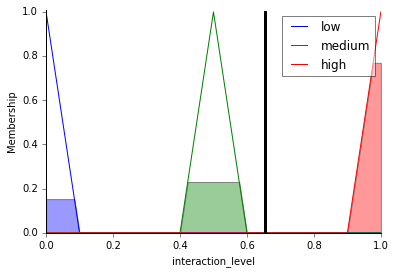

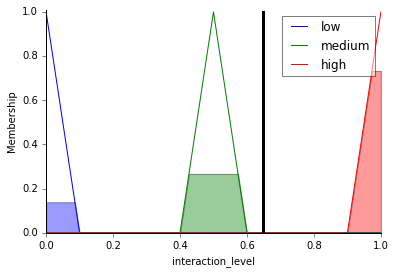

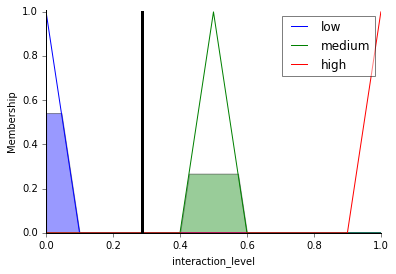

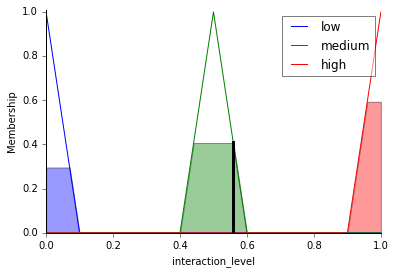

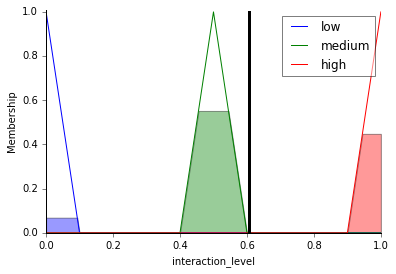

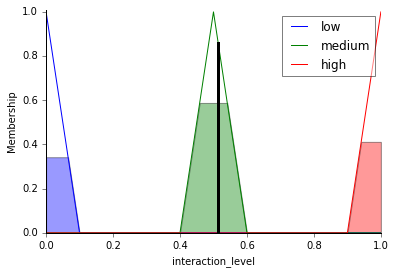

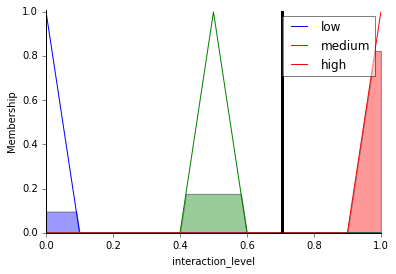

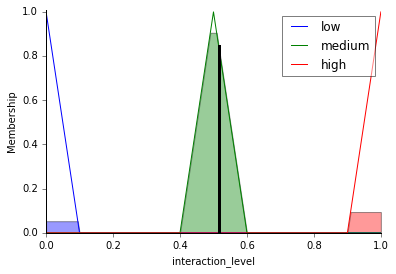

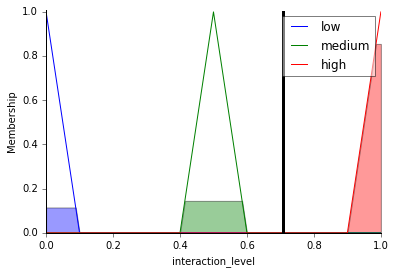

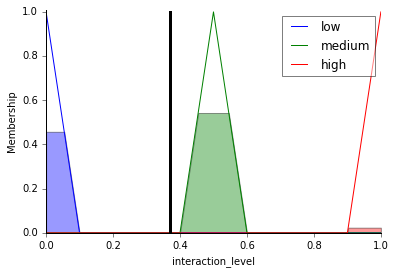

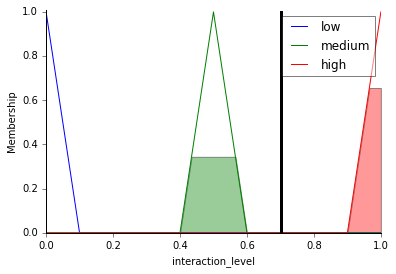

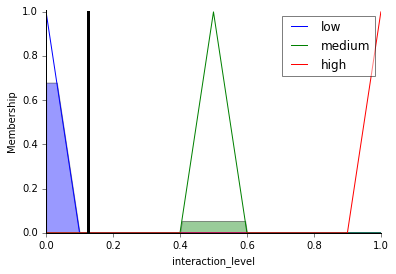

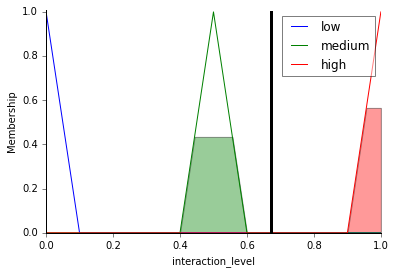

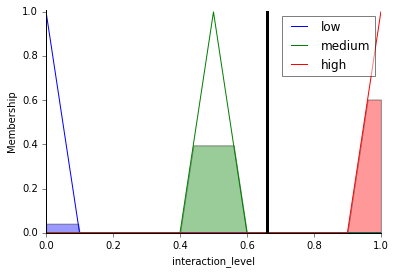

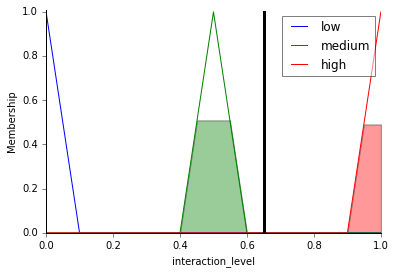

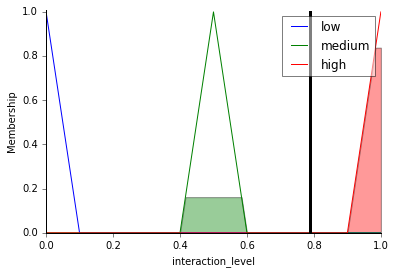

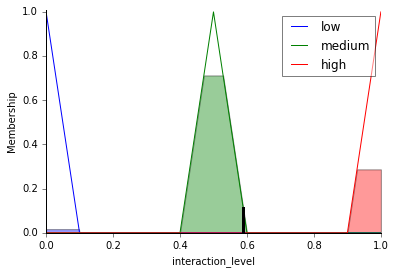

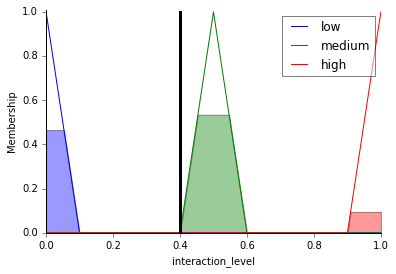

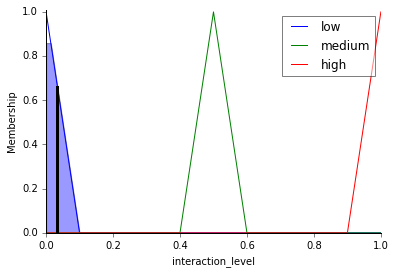

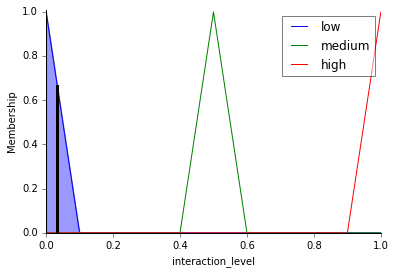

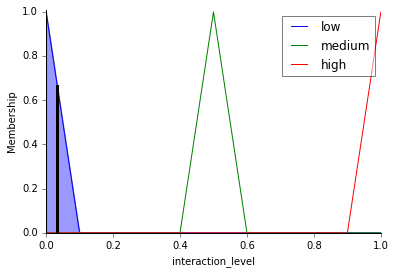

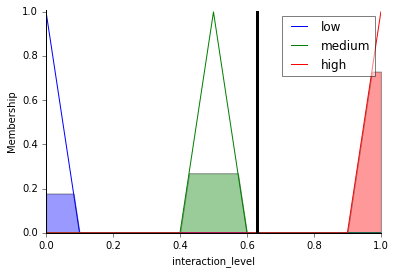

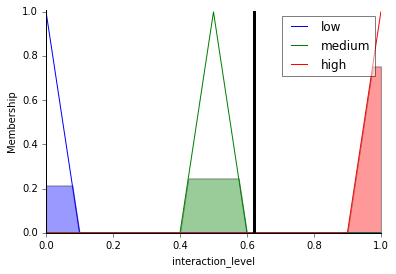

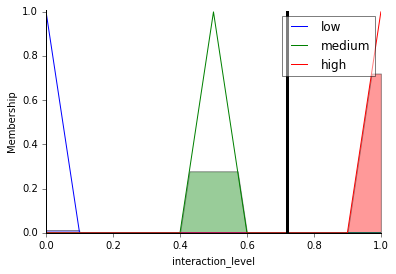

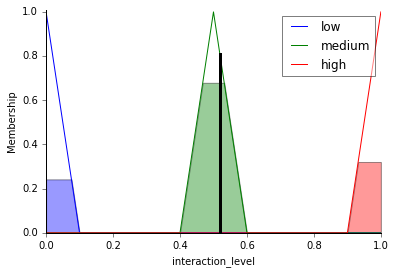

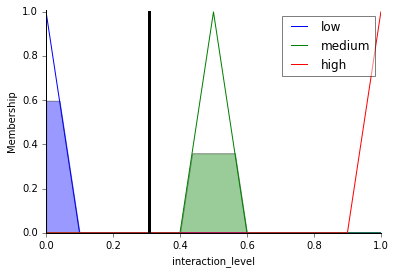

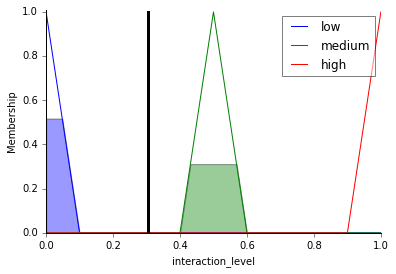

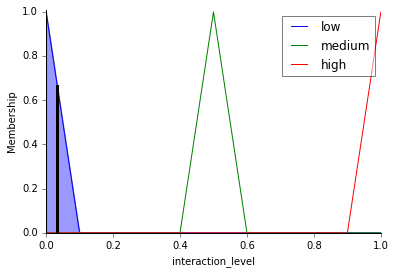

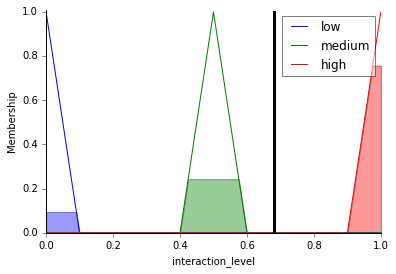

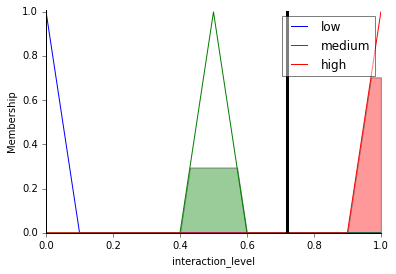

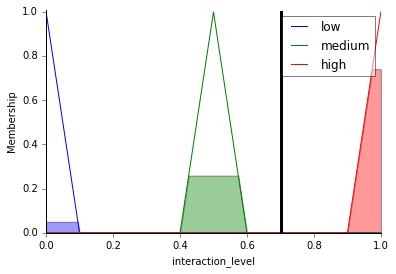

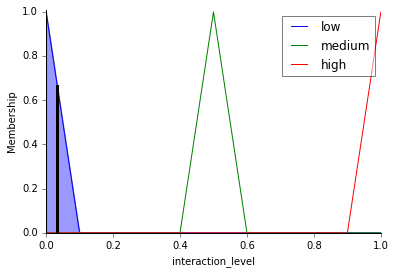

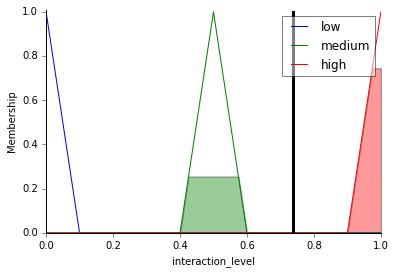

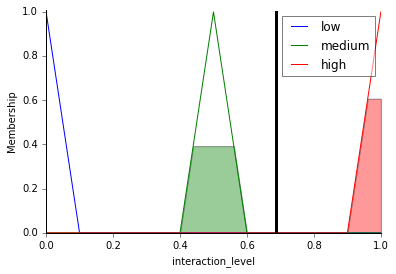

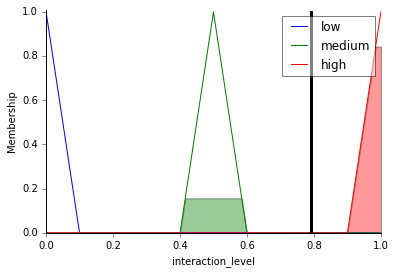

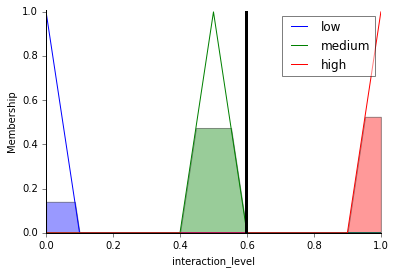

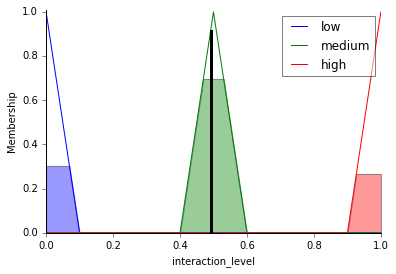

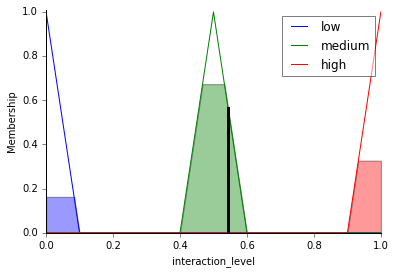

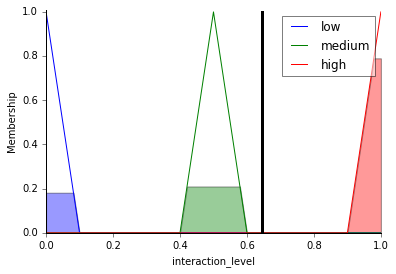

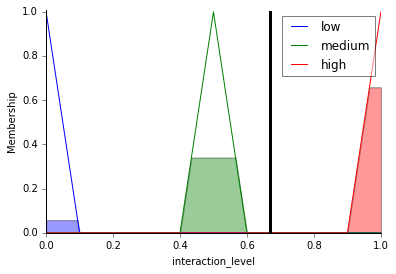

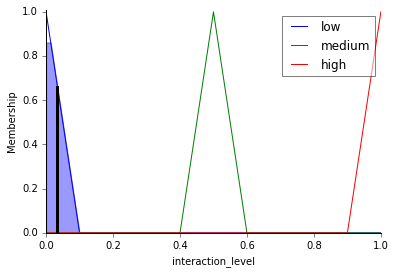

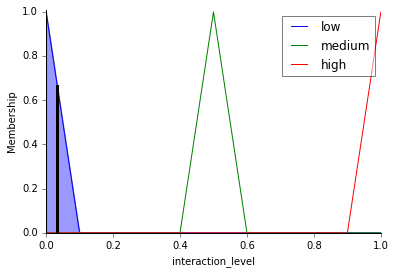

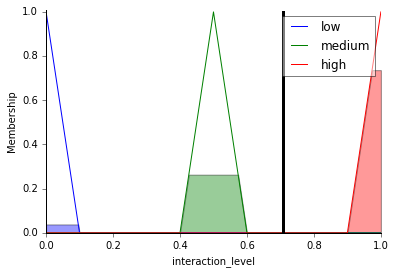

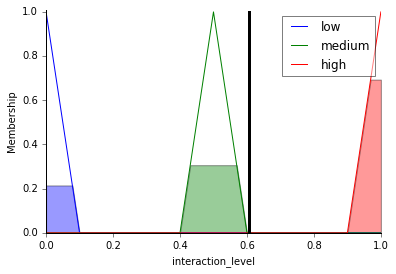

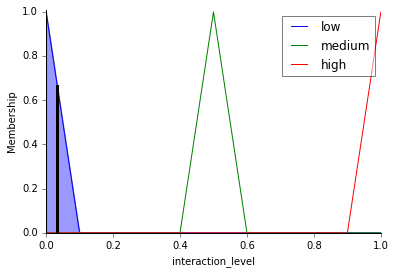

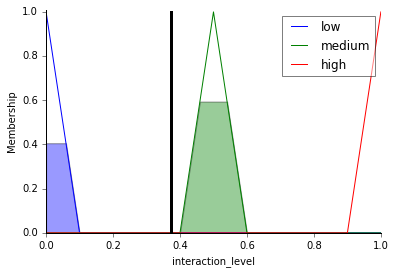

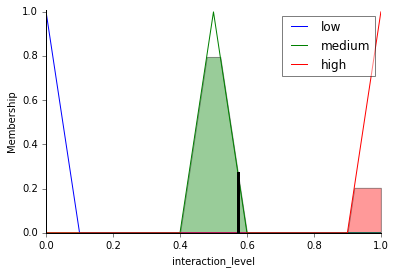

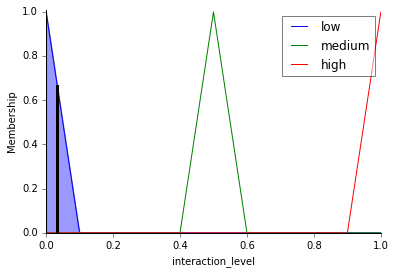

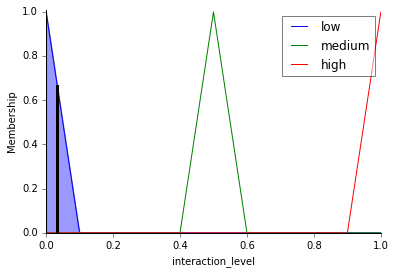

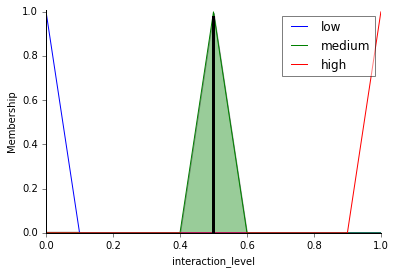

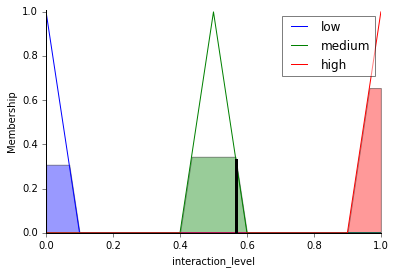

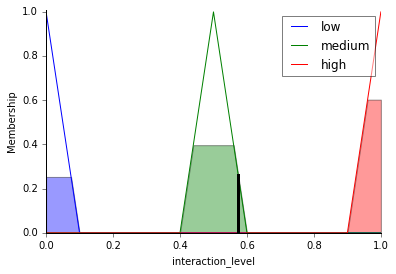

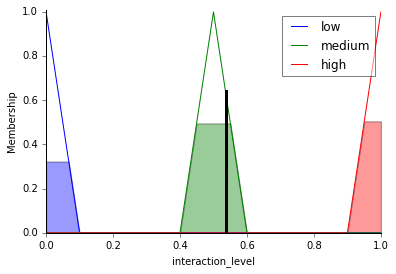

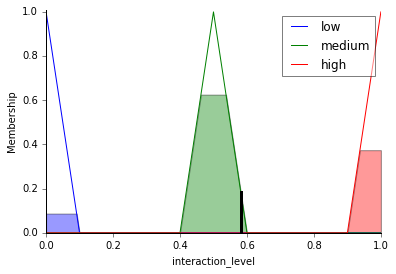

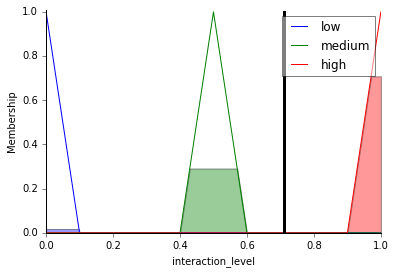

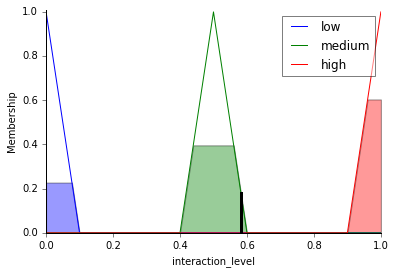

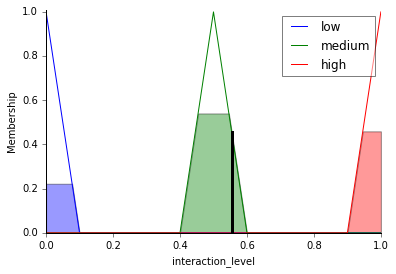

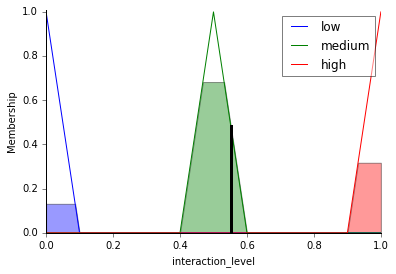

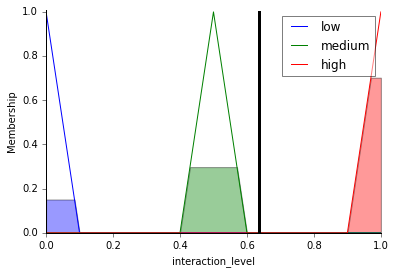

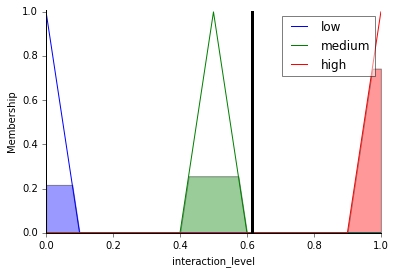

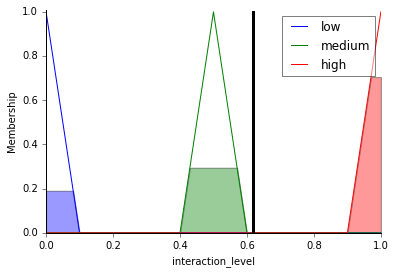

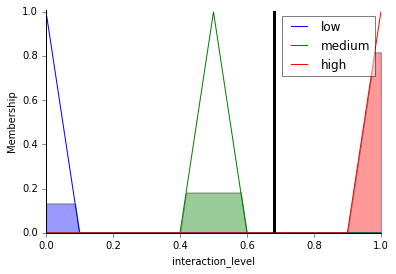

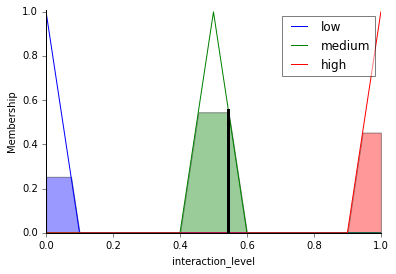

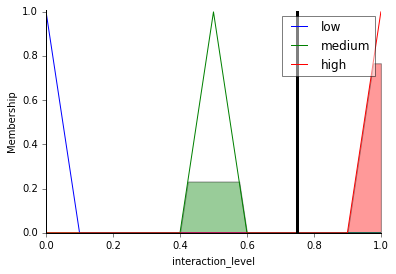

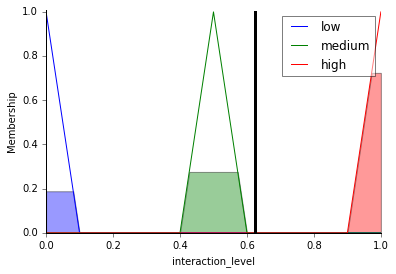

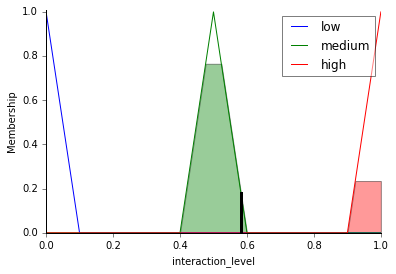

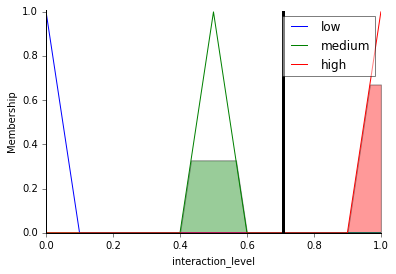

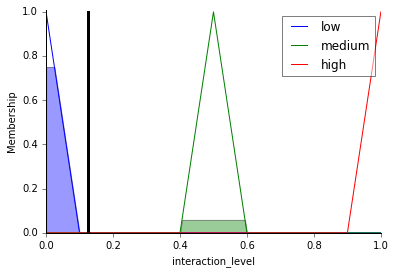

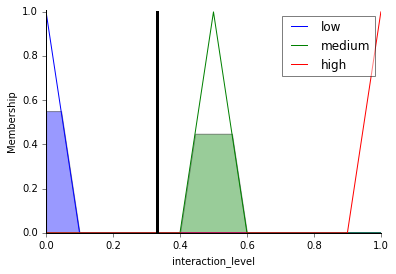

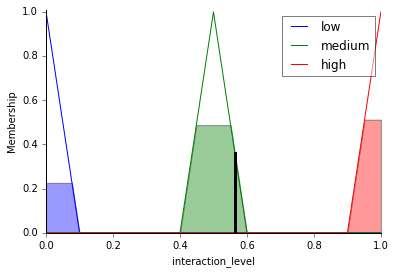

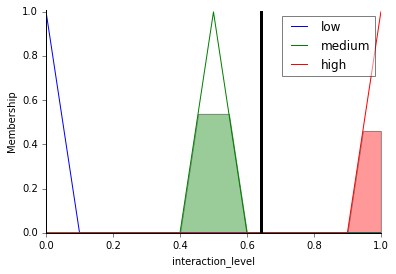

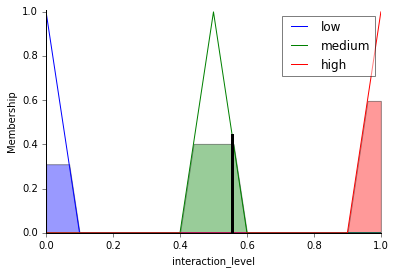

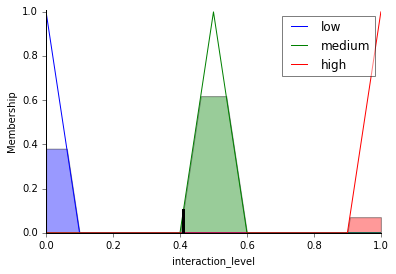

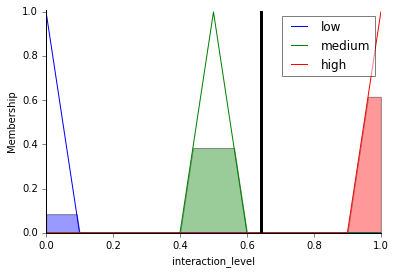

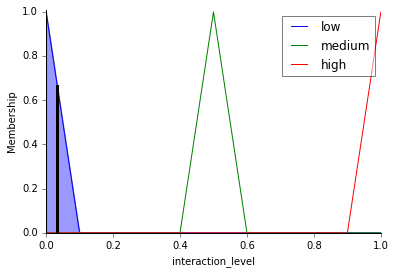

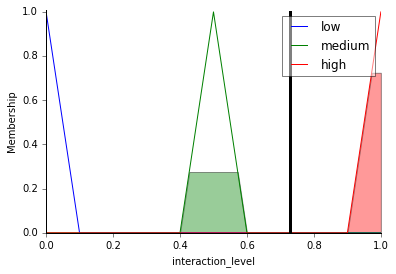

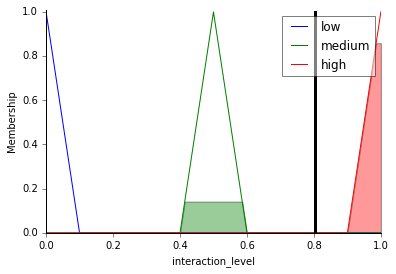

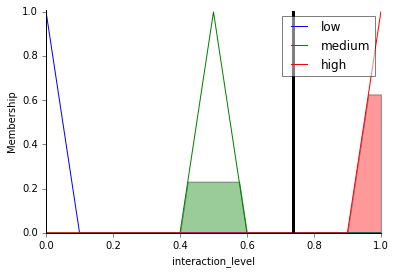

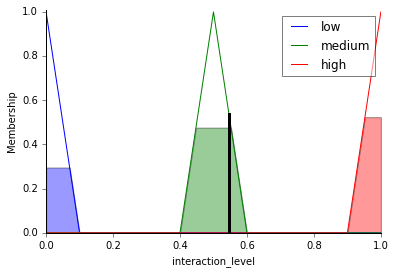

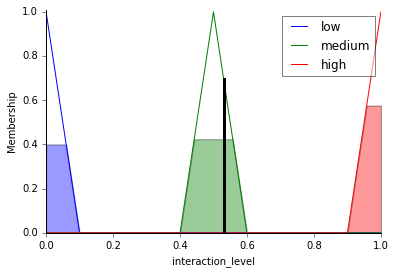

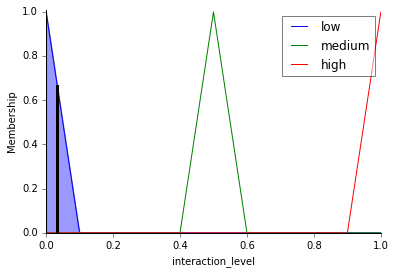

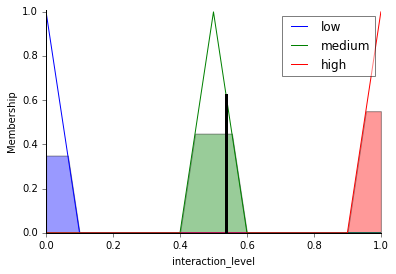

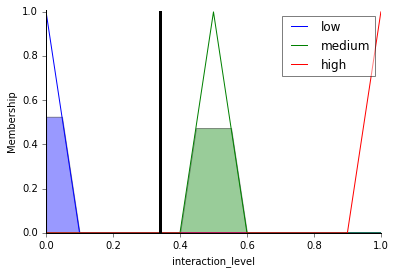

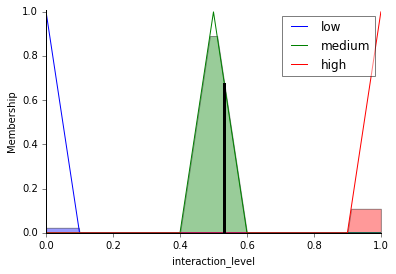

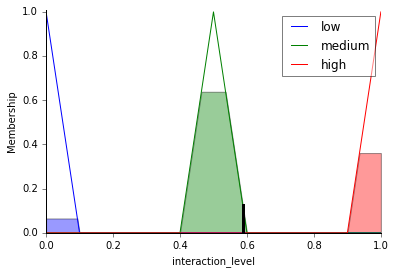

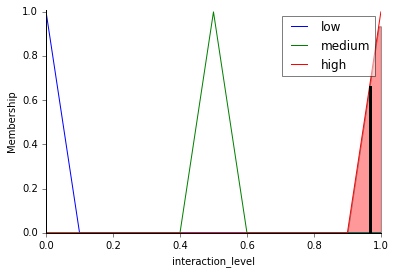

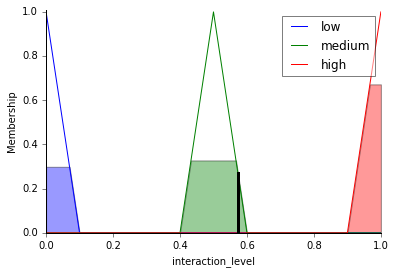

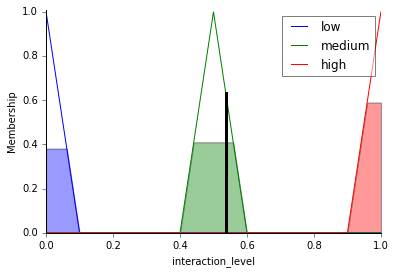

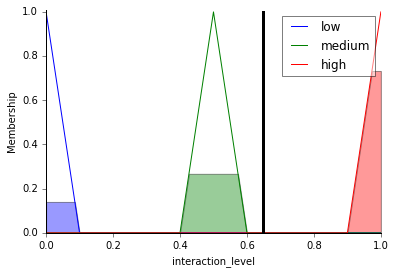

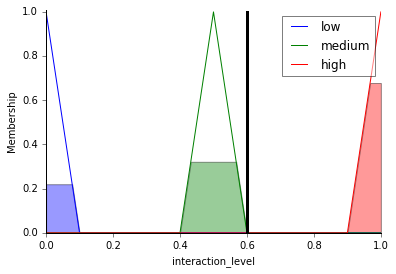

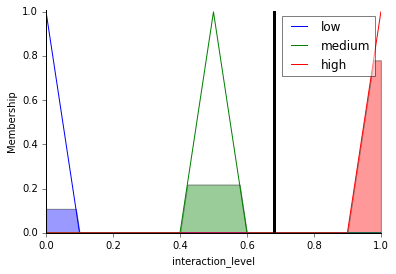

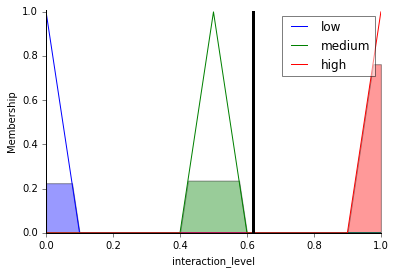

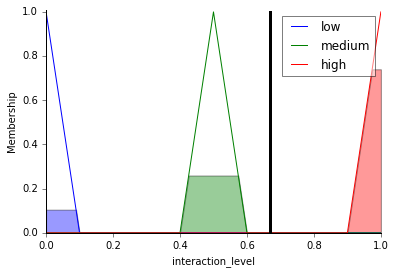

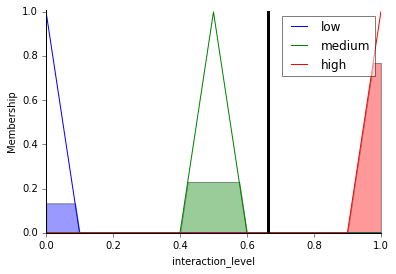

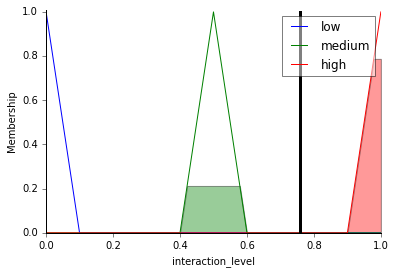

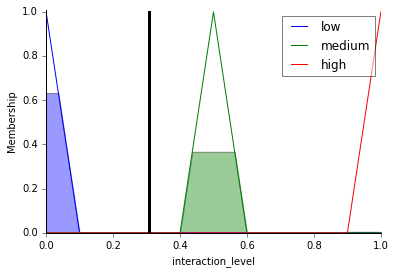

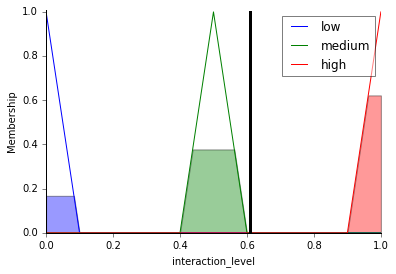

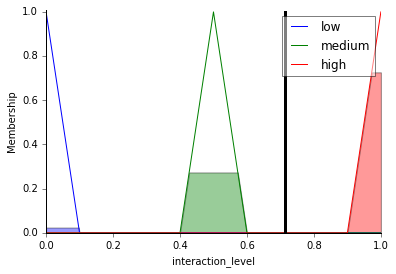

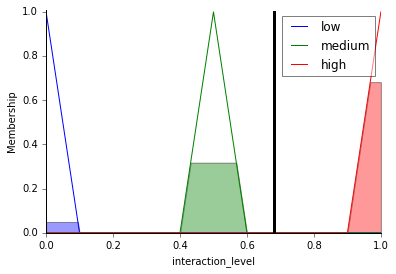

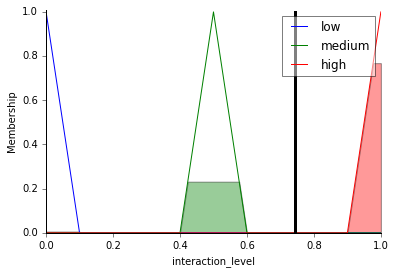

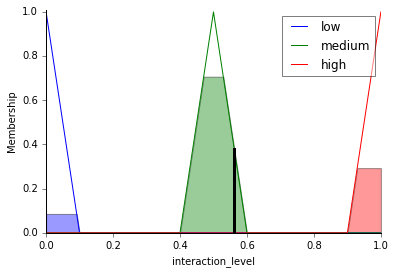

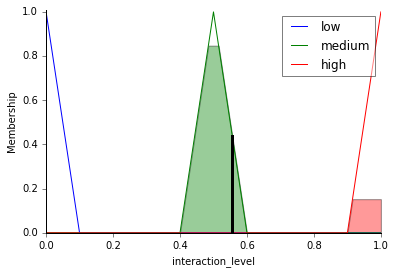

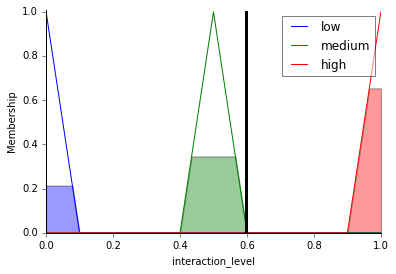

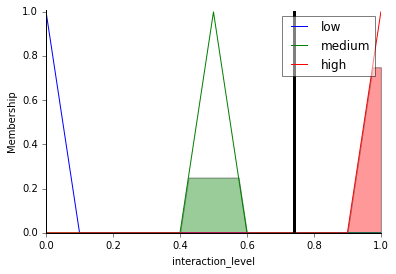

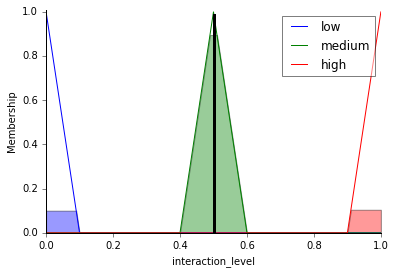

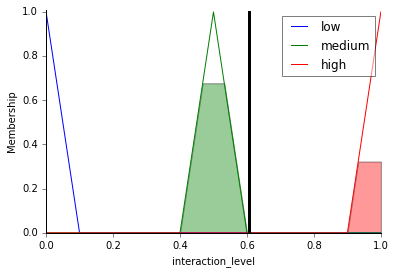

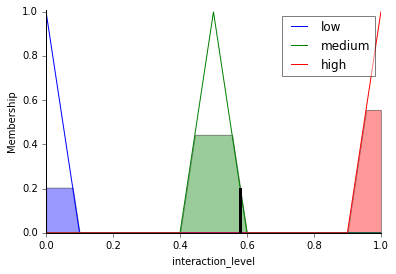

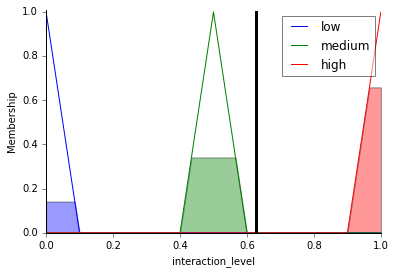

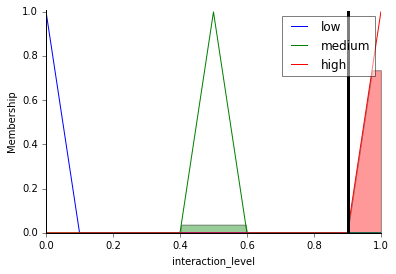

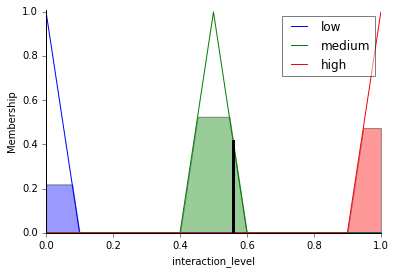

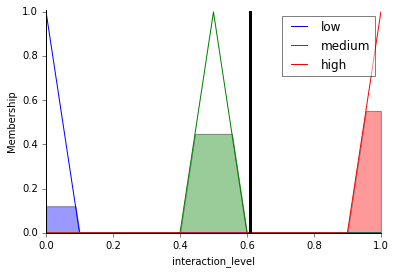

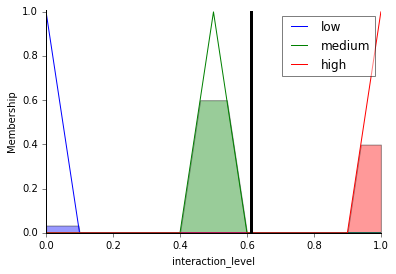

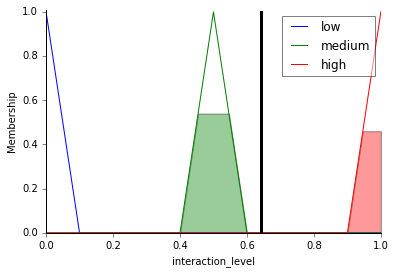

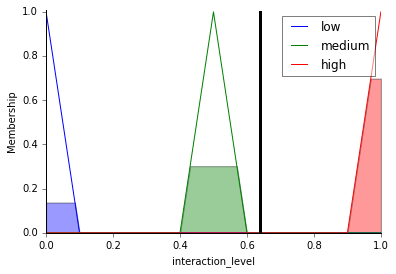

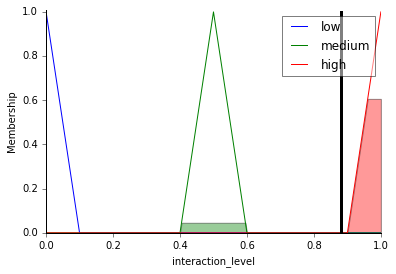

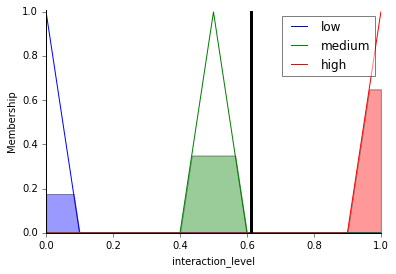

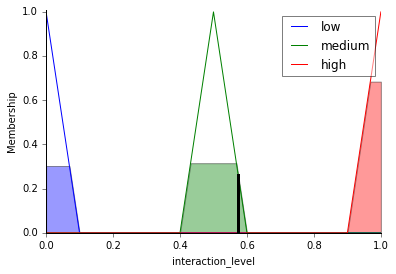

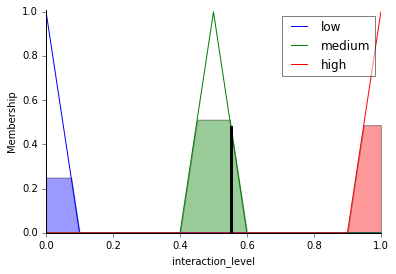

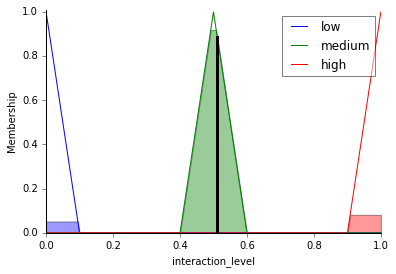

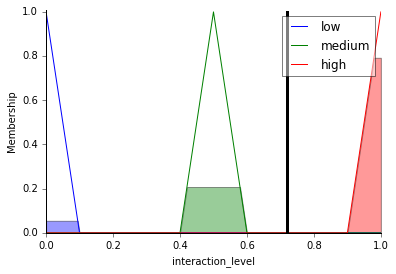

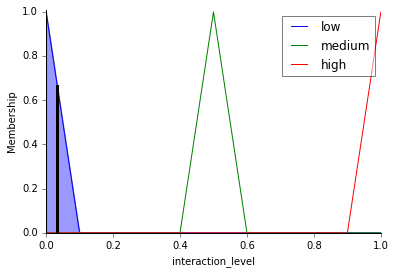

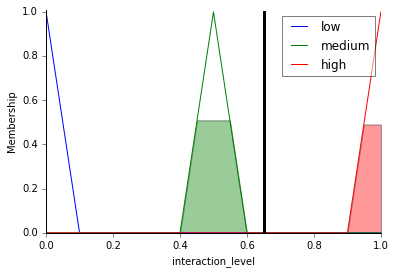

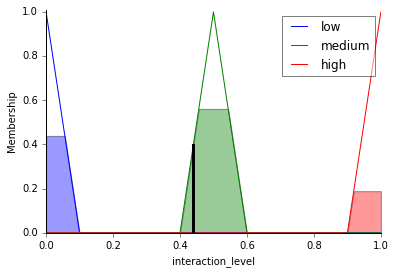

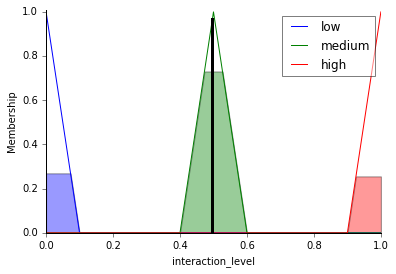

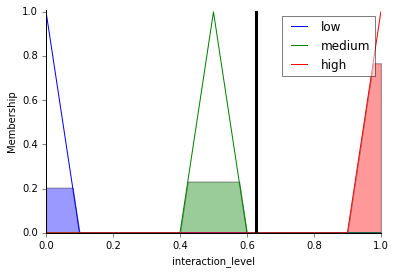

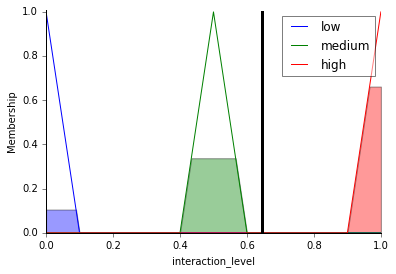

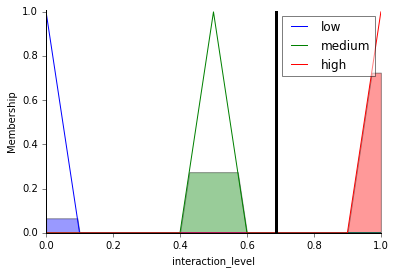

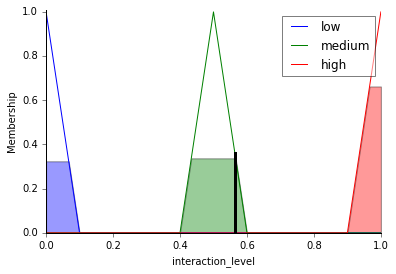

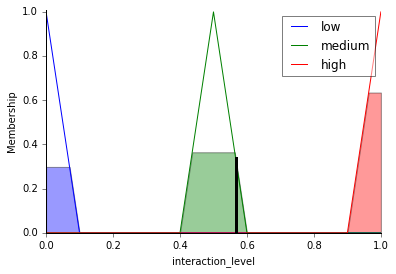

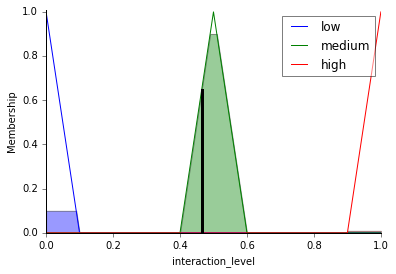

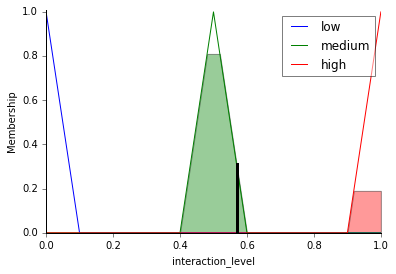

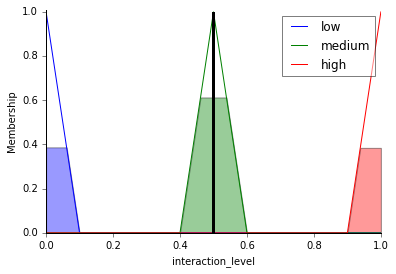

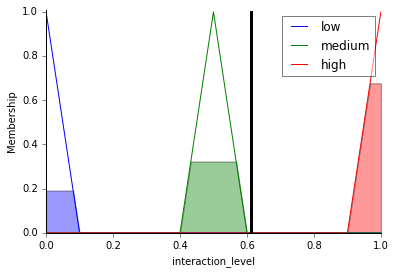

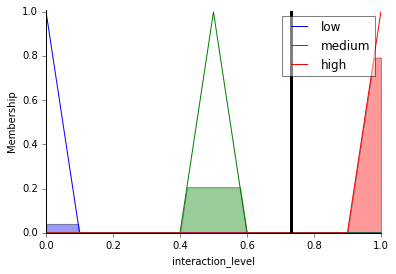

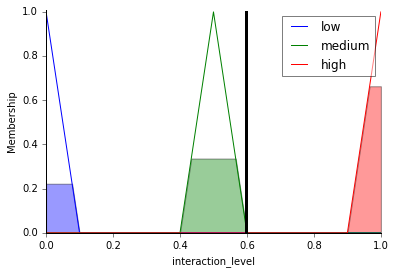

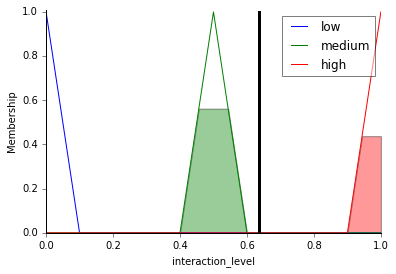

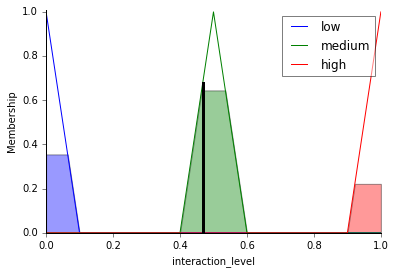

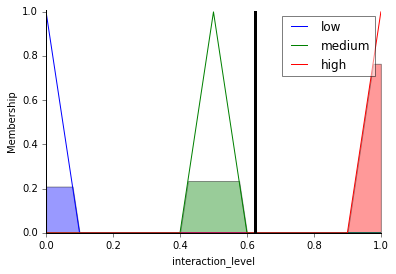

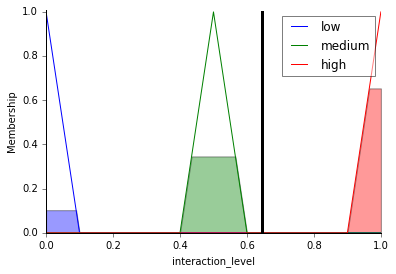

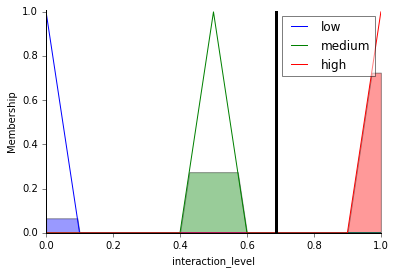

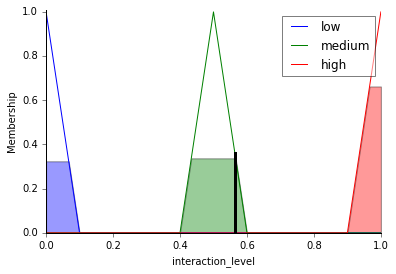

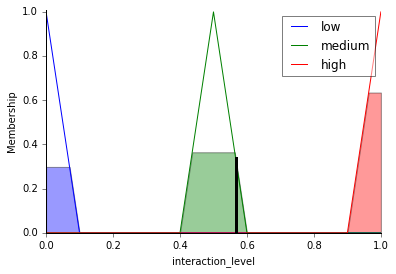

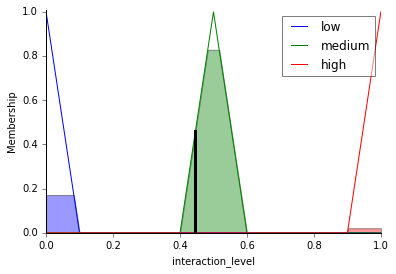

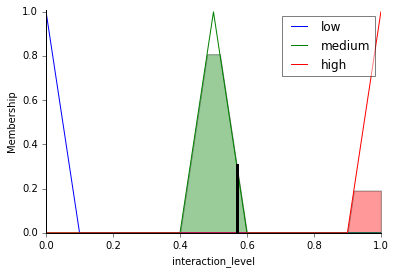

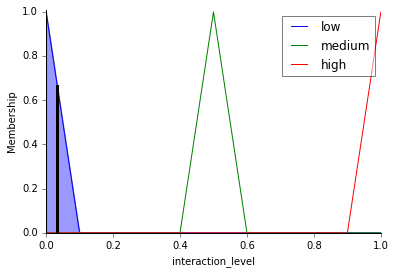

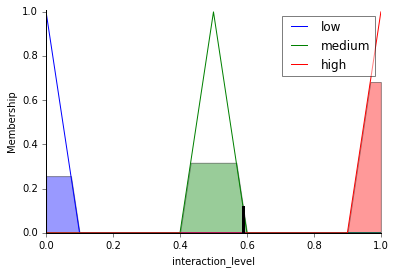

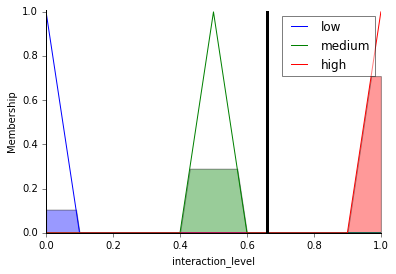

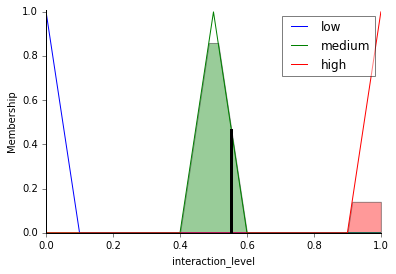

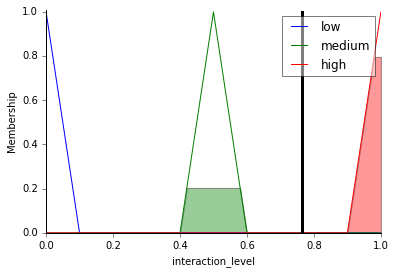

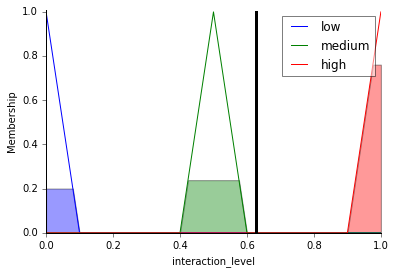

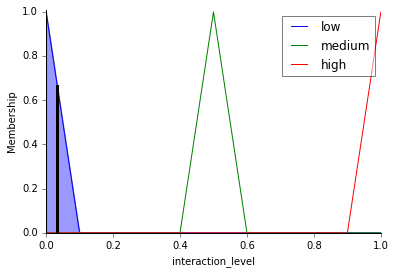

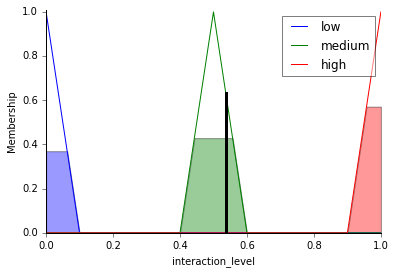

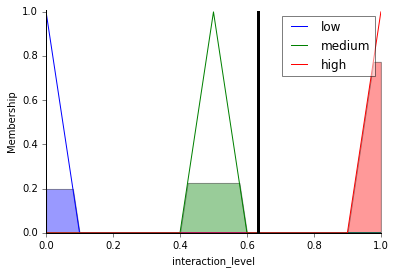

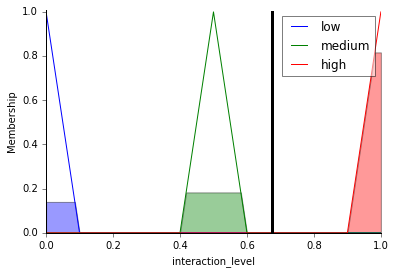

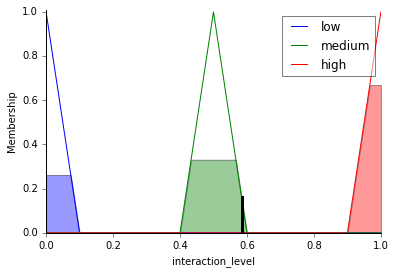

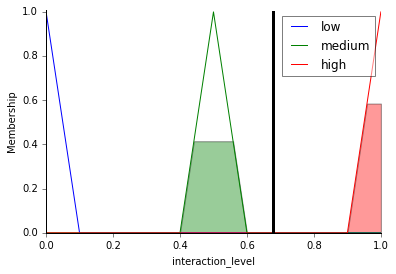

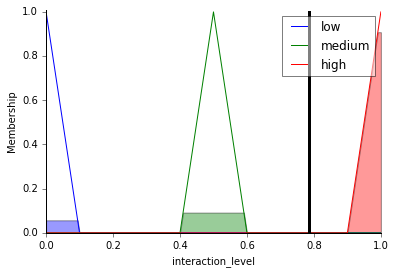

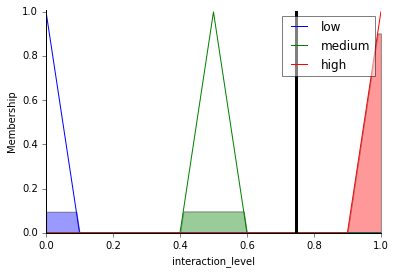

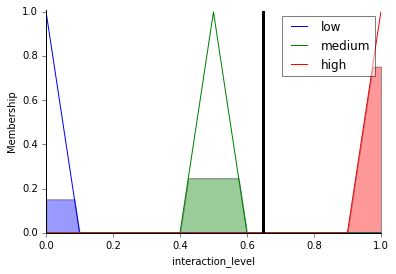

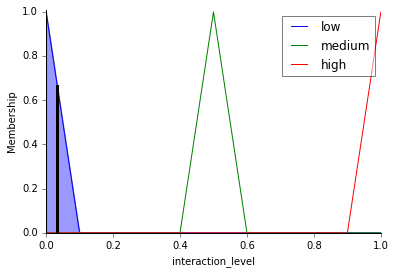

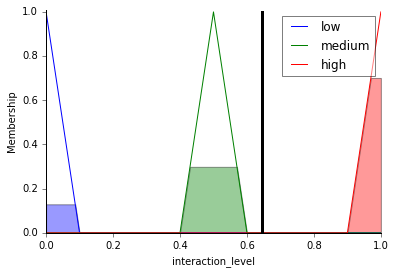

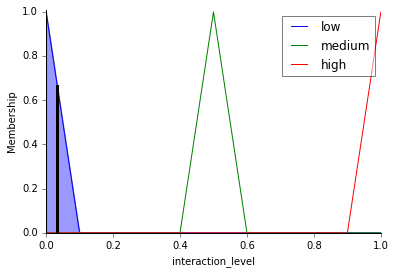

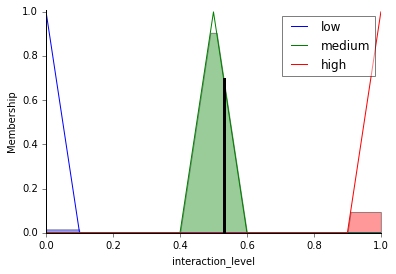

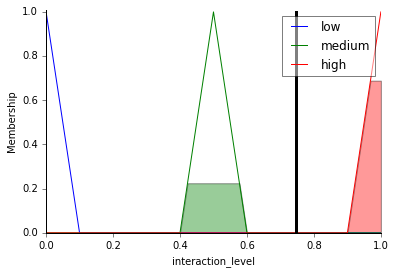

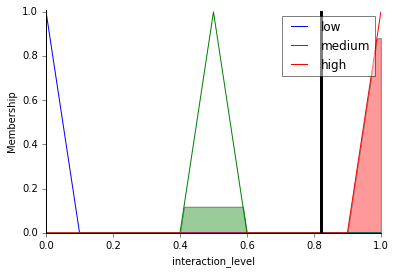

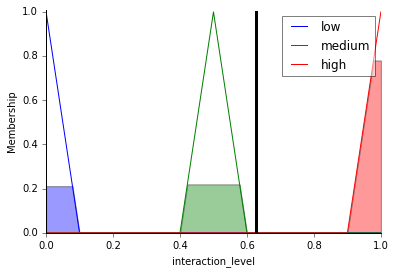

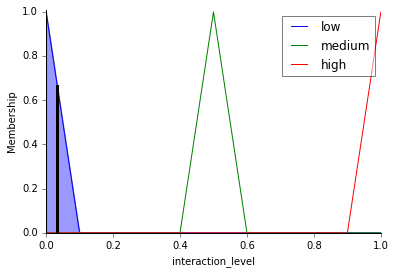

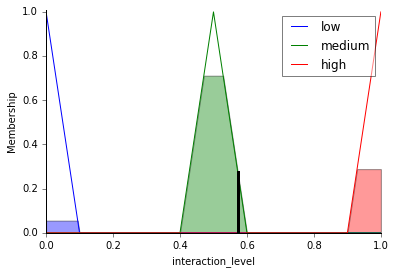

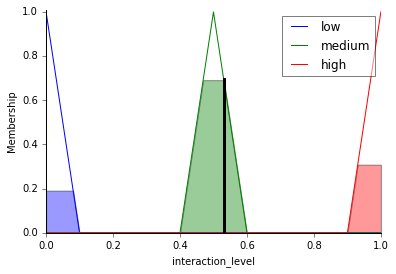

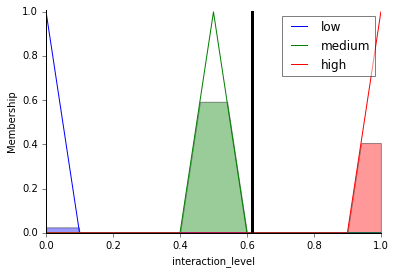

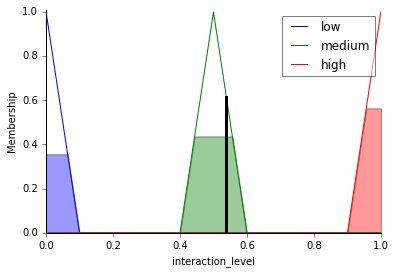

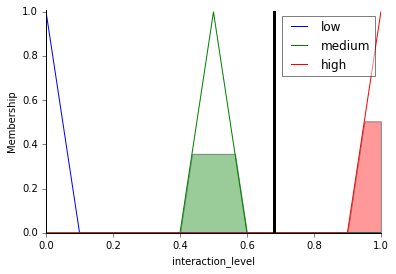

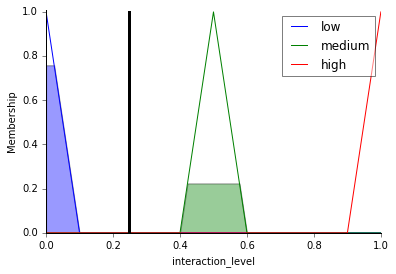

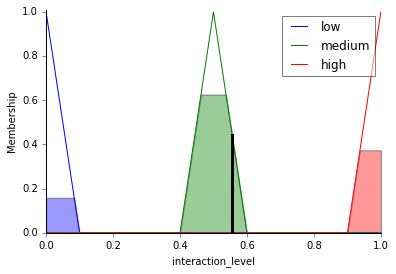

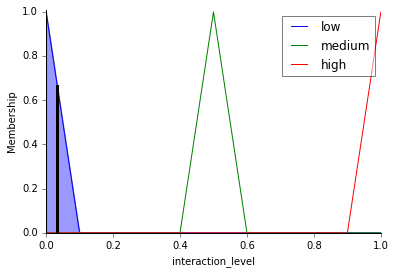

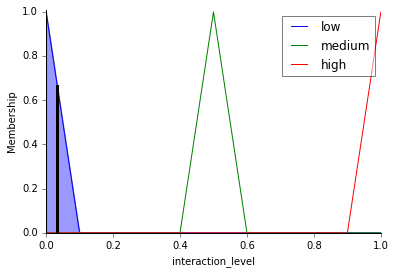

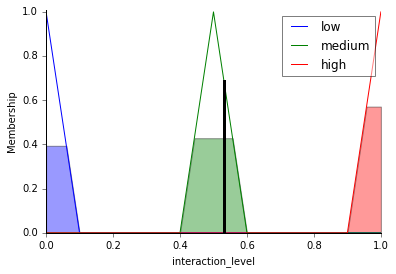

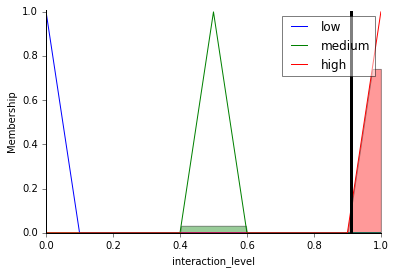

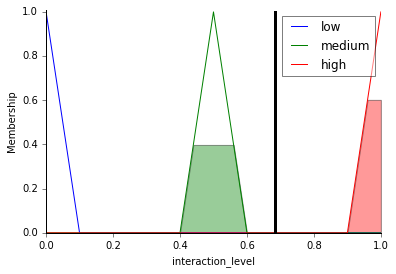

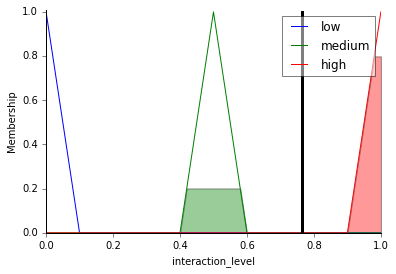

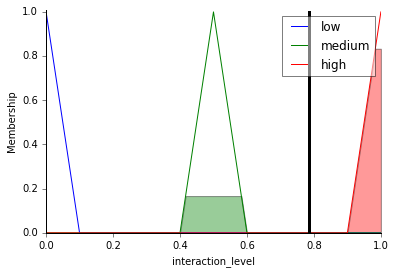

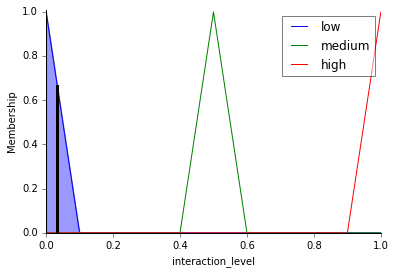

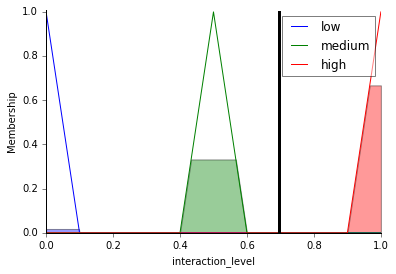

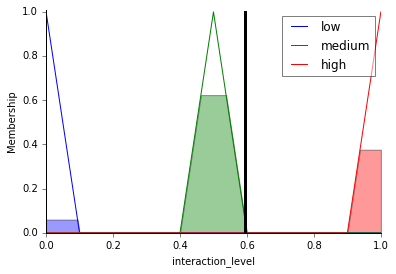

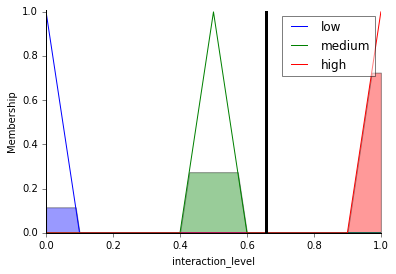

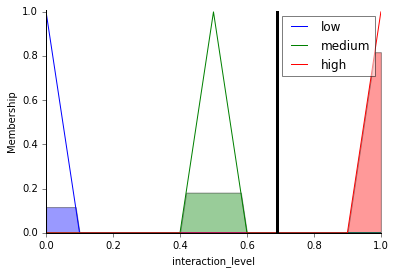

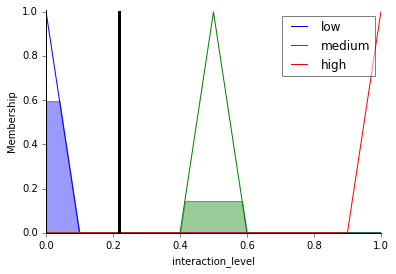

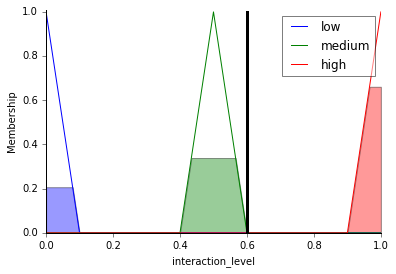

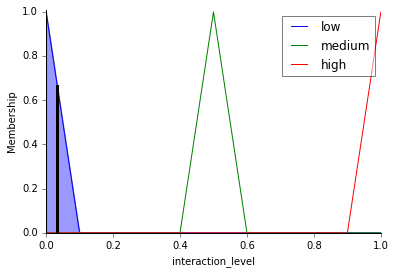

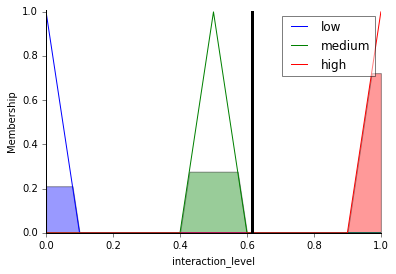

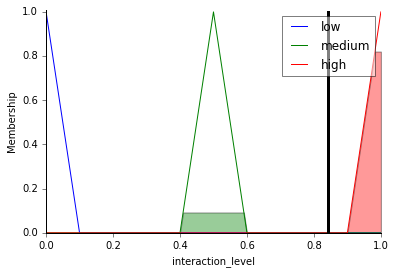

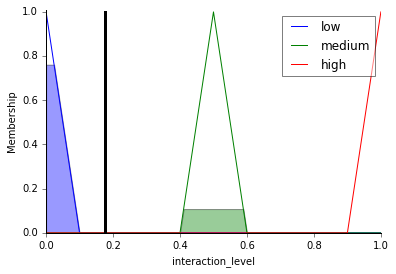

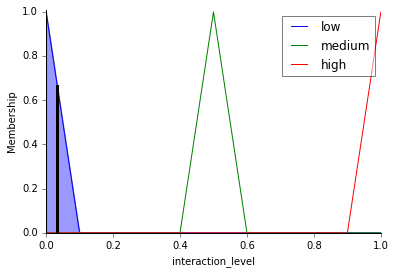

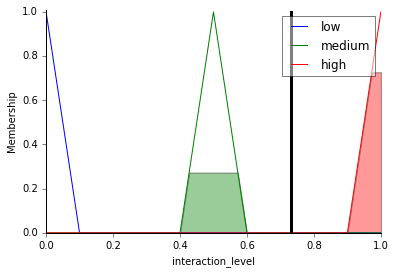

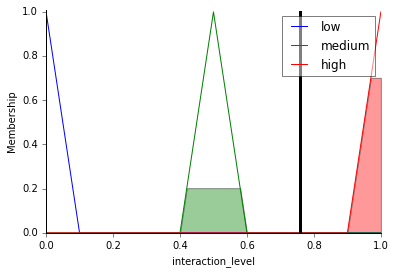

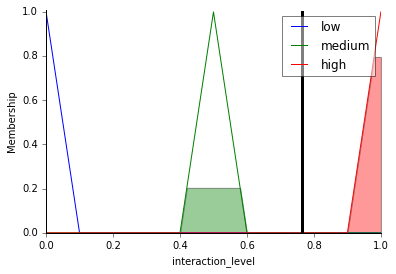

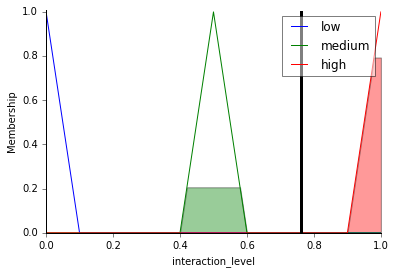

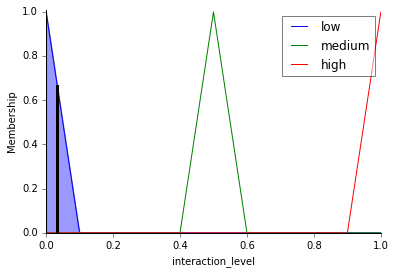

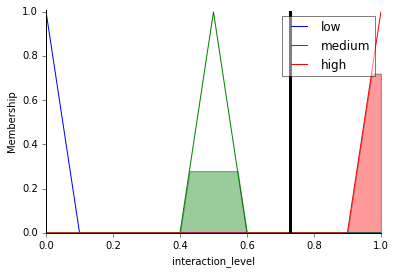

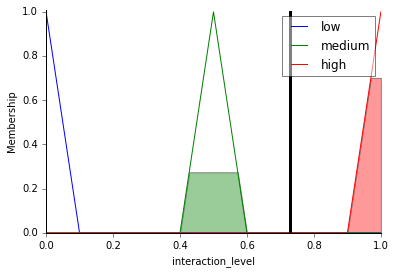

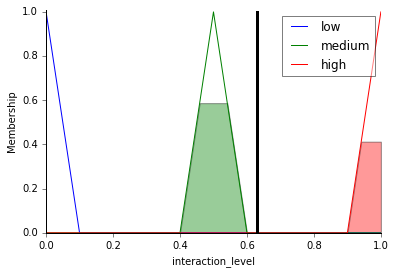

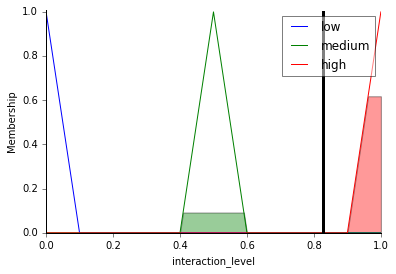

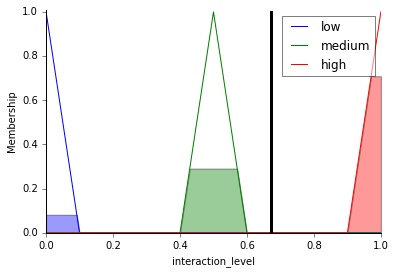

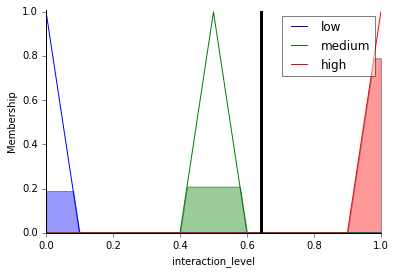

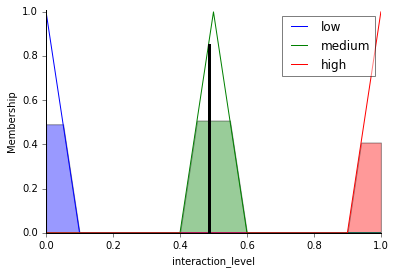

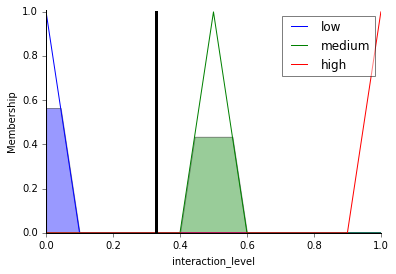

In [46]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
ci = ctrl.Antecedent(np.arange(0, 1.1, .1), 'ci')
proximity = ctrl.Antecedent(np.arange(0, 1.1, .1), 'proximity')
interaction_level = ctrl.Consequent(np.arange(0, 1.1, .1), 'interaction_level')

# membership function population
ci['low'] = fuzz.trapmf(ci.universe, [0,0,.1,.5])
ci['medium'] = fuzz.trimf(ci.universe, [.1, .5, .9])
ci['high'] = fuzz.trapmf(ci.universe, [.5, .9, 1, 1])
proximity['low'] = fuzz.trapmf(proximity.universe, [0,0,.1,.5])
proximity['medium'] = fuzz.trimf(proximity.universe, [.1, .5, .9])
proximity['high'] = fuzz.trapmf(proximity.universe, [.5, .9, 1, 1])

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
interaction_level['low'] = fuzz.trapmf(interaction_level.universe, [0,0,0,0])
interaction_level['medium'] = fuzz.trapmf(interaction_level.universe, [.5, .5, .5,.5])
interaction_level['high'] = fuzz.trimf(interaction_level.universe, [1, 1, 1])

rule1 = ctrl.Rule(ci['low'] & proximity['low'], interaction_level['low'])
rule2 = ctrl.Rule(ci['medium'] & proximity['medium'], interaction_level['medium'])
rule3 = ctrl.Rule(ci['high'] & proximity['high'], interaction_level['high'])
rule4 = ctrl.Rule(ci['low'] & proximity['high'], interaction_level['medium'])
rule5 = ctrl.Rule(ci['high'] & proximity['low'], interaction_level['medium'])
rule6 = ctrl.Rule(ci['low'] & proximity['medium'], interaction_level['low'])
rule7 = ctrl.Rule(ci['medium'] & proximity['low'], interaction_level['low'])
rule8 = ctrl.Rule(ci['medium'] & proximity['high'], interaction_level['high'])
rule9 = ctrl.Rule(ci['high'] & proximity['medium'], interaction_level['high'])


interaction_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
interaction_out = ctrl.ControlSystemSimulation(interaction_ctrl)
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)

for ind,i in enumerate(proc_res):
    print 'iteration: {}'.format(ind)
    c = None
    p = None

    if np.isnan(i[0]):
        c = 0
    else:
        c = i[0]
    if np.isnan(i[1]):
        p = 0
    else:
        p = i[1]
    
    #print 'Ci={}, prox= {}'.format(c,p)
    interaction_out.input['ci'] = c
    interaction_out.input['proximity'] = p


    
    # Crunch the numbers
    interaction_out.compute()


    result = interaction_out.output['interaction_level']
    
    print 'interaction_level: {}'.format(result)
    
    k= None
    if result < 0.3:
        k = 1
    elif (result >= 0.3) and (result < 0.6):
        k = 2
    elif (result >= 0.6) and (result < 1):
        k = 3
    print 'gain factor: {}'.format(k)
    
    interaction_level.view(sim=interaction_out)
    print
